In [ ]:
# %tensorflow_version 1.15
# !pip install 'h5py==2.10.0' --force-reinstall


#import tensorflow.compat.v1.keras.backend as K
import keras.backend as K
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
import tensorflow
from tensorflow.keras.optimizers import Adam

import sys
import numpy as np
from pathlib import Path
import IPython
from keras import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, History
import numpy as np
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, TimeDistributed, Conv1D, Conv1DTranspose, Input, LeakyReLU, MaxPooling1D, Flatten, Lambda, Reshape, Add, BatchNormalization, Dropout,Concatenate, Dot, RepeatVector, Multiply, MultiHeadAttention, LayerNormalization, Conv2D, Conv2DTranspose


#from keras import backend as K
from IPython.display import Image
import cv2
from scipy.io import wavfile
import os
import matplotlib.pyplot as plt
#from keras.utils import plot_model
import matplotlib.pyplot as plt
import keras

print("TF Version: " + tensorflow.__version__)
print("Keras Version: " + keras.__version__)
from keras.layers.pooling import AveragePooling1D
from keras.layers.convolutional import UpSampling1D


#from keras import backend as K
import pickle


from music21 import note,chord, instrument,stream
from IPython.display import Audio

from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

#tf.compat.v1.disable_eager_execution()

!pip install jyquickhelper
!pip install pathlib

!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

def generate_midi_song(notes_array):
  offset = 0
  output_notes = []
  for a in range(notes_array.shape[0]):
    notes_in_step = []
    xd = 0
    for b in notes_array[a,:]:
      if b == 1:
        notes_in_step.append(xd)
      xd += 1
    length = len(notes_in_step)
    if length == 0:
      rest = note.Rest()
      rest.offset = offset
      output_notes.append(rest)
    if length > 0:
      notes_objects = []
      for note_num in notes_in_step:
        new_note = note.Note(int(note_num+24))
        new_note.storedInstrument = instrument.Piano()
        notes_objects.append(new_note)
      new_chord = chord.Chord(notes_objects)
      new_chord.offset = offset
      #print(new_chord)
      output_notes.append(new_chord)
    offset += 0.25

  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp="this.mid")

TF Version: 2.7.0
Keras Version: 2.7.0
     |████████████████████████████████| 1.5 MB 8.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 l

In [ ]:
SEQ_LENGTH = 128

# The dataset
with open('/content/drive/MyDrive/BATCH/notesALLSCALES_A_seq_len.npy', 'rb') as f:
    notes = np.load(f)

with open('/content/drive/MyDrive/BATCH/notesALLSCALES_B_seq_len.npy', 'rb') as f:
    notes = np.concatenate((notes, np.load(f)), axis = 0)
    
with open('/content/drive/MyDrive/BATCH/notesALLSCALES_C_seq_len.npy', 'rb') as f:
    notes = np.concatenate((notes, np.load(f)), axis = 0)

with open('/content/drive/MyDrive/BATCH/notesALLSCALES_1_seq_len.npy', 'rb') as f:
    notes = np.concatenate((notes, np.load(f)), axis = 0)

notes = np.asarray(notes)

#notes = np.concatenate((notes,notes2,notes3),axis = 0) #notes4

notes = notes[:,:SEQ_LENGTH,:]

np.random.seed(42)
np.random.shuffle(notes)

split_point = int(notes.shape[0] * 14 / 15)
x_train, x_test = notes[0:split_point,:], notes[split_point:-1,:]
# np.savez("music.npz", x_train=x_train,x_test=x_test)
# x_train = normalized_input

shp = x_train.shape

print("x_train.shape:", x_train.shape)
print("x_test.shape:", x_test.shape)

%reset_selective -f notes


x_train.shape: (32144, 128, 72)
x_test.shape: (2296, 128, 72)


In [ ]:
MOMENTUM = 0.90
DROP_RATE = 0.05

def residual_context_block(X, filters,Strids, kernel_1, kernel_3, transpose=False, upsampling=False,maxpooling=False, padding='causal', dropout=False):

  X_start = X 

  X_1 = Conv1D(filters, kernel_1, strides=Strids, activation=None, padding=padding )(X_start)
  
  if dropout:
    #X_1 = LayerNormalization(axis=2 , center=True , scale=True)(X_1)
    X_1 = Dropout(rate=DROP_RATE)(X_1)

  X_3 = Conv1D(filters, kernel_3, strides=Strids, activation=None, padding=padding )(X_start)

  if dropout:
    #X_3 = LayerNormalization(axis=2 , center=True , scale=True)(X_3)
    X_3 = Dropout(rate=DROP_RATE)(X_3)

  #X = Concatenate(axis=-1)([X_1, X_3])
  X = Add()([X_1, X_3])
  X = LeakyReLU()(X)

  if transpose:
    X = Conv1DTranspose(filters*2 ,3, strides=2, activation=None, padding='same' )(X)
    X = LeakyReLU()(X)
    if dropout:
      X = Dropout(rate=DROP_RATE)(X)
  if upsampling:
    X = UpSampling1D(2)(X)
  if maxpooling:
    X = MaxPooling1D(2)(X)

  print(X.shape)
  return X

In [ ]:
# BUILD THE MODEL

latent_dim = 256 # 256 * 8 time dimension

NUMBER_OF_NOTES = 72



input_shp = (SEQ_LENGTH , NUMBER_OF_NOTES)
enc_input = Input(shape = input_shp) # The original image or sound

x = TimeDistributed(Dense(NUMBER_OF_NOTES))(enc_input) # Second fully connected with sigmoid activation
x = LeakyReLU()(x)
print(x.shape)

#x = residual_context_block(x, 64, 1, 9, 5, padding='causal')
x = Conv1D(32,7,1,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)

x = Conv1D(64,7,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)

x = Reshape((64,64,1))(x)

x = Conv2D(128,5,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)

x = Conv2D(256,5,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)

x = Conv2D(512,3,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)

x = Conv2D(512,3,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)

# x = residual_context_block(x, 512, 1, 7, 3, maxpooling=True, padding='same')
# x = residual_context_block(x, 512, 1, 5, 3, maxpooling=True, padding='same')

#x = residual_context_block(x, 256, 1, 5, 3, maxpooling=True, padding='same')

#Flatten

x = Flatten()(x)

x = Dense(latent_dim*4)(x)
x = LeakyReLU()(x)

z_mean = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma' )(x)  #Std dev. (variance) of encoded input

#REPARAMETERIZATION TRICK
def sample_z(args):
  z_mean, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mean)),mean=0.0,stddev=0.2)
  return z_mean + K.exp(z_sigma * 0.5) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mean, z_sigma])


encoder = Model(enc_input, [z_mean, z_sigma, z], name='encoder')
print(f"encoder number of parameters: {encoder.count_params():,}\n\n\n"  )

#print(encoder.summary())

# ================= ###########
# Decoder
# ================= #################

decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
# x = Dropout(DROP_RATE)(x)

# x = Dense(latent_dim*4)(decoder_input) ###################  1
# x = LeakyReLU()(x)
# x = Reshape((8,128))(x)
# print("dense x 4", x.shape)
# x = Conv1D(256,1,1,padding='same')(x)
# print("conv: ", x.shape)

x = Dense(latent_dim*4)(decoder_input) ###################  1
x = Reshape((4,2,128))(x)
x = LeakyReLU()(x)

# x = residual_context_block(x, 512,1, 1, 4, upsampling=True,padding='same', dropout=True)
# x = residual_context_block(x, 512,1, 2, 5, upsampling=True,padding='same', dropout=True)
#x = residual_context_block(x, 512,  1, 3, 5, padding='same', dropout=True)
print(x.shape)

x = Conv2DTranspose(1024,3,2,padding='same')(x)
x = LeakyReLU()(x)

x = Conv1D(128,3,2,padding='same')(x)


print(x.shape)
x = Conv2DTranspose(512,3,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)
x = Conv2DTranspose(256,5,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)
x = Conv2DTranspose(128,5,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)
x = Conv2DTranspose(64,5,2,padding='same')(x)
x = LeakyReLU()(x)
print(x.shape)

x = Reshape((128,-1))(x)
print(x.shape)

x = TimeDistributed(Dense(256, activation=None))(x) # Second fully connected with sigmoid activation
x = LeakyReLU()(x)

x = TimeDistributed(Dense(NUMBER_OF_NOTES, activation='sigmoid'))(x) # Second fully connected with sigmoid activation

decoder = Model(decoder_input, x, name='decoder')
print(f"decoder number of parameters: {decoder.count_params():,}"  )

# decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)


# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -0.2 * K.mean(1 + z_sigma - K.square(z_mean) - K.exp(z_sigma), axis=-1) ## -0.05 
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([enc_input, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

# =================
# VAE 
# =================
vae = Model(enc_input, y, name='vae')
print(f"vae number of parameters: {vae.count_params():,}"  )
# Compile VAE
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=None) 

(None, 128, 72)
(None, 128, 32)
(None, 64, 64)
(None, 32, 32, 128)
(None, 16, 16, 256)
(None, 8, 8, 512)
(None, 4, 4, 512)
encoder number of parameters: 13,313,000



(None, 4, 2, 128)
(None, 8, 2, 128)
(None, 16, 4, 512)
(None, 32, 8, 256)
(None, 64, 16, 128)
(None, 128, 32, 64)
(None, 128, 2048)
decoder number of parameters: 7,271,816
vae number of parameters: 20,584,816


In [ ]:
vae.load_weights('/content/drive/MyDrive/models/vaeBachC_vol_8CNN2.h5')

In [ ]:
BATCH_SIZE = 64

In [ ]:
history = vae.fit(x_train, None, epochs = 10 , batch_size = BATCH_SIZE, validation_split=0.1, shuffle=True) #lr = 0.0003 loss: 0.0151

vae.save_weights('/content/drive/MyDrive/models/vaeBachC_vol_8CNN2.h5')
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC_vol_8CNN2.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
history = vae.fit(x_train, None, epochs = 20 , batch_size = BATCH_SIZE, validation_split=0.1,shuffle=True) # loss: 0.0036

vae.save_weights('/content/drive/MyDrive/models/vaeBachC2_vol_8CNN2.h5')
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC2_vol_8CNN2.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Train on 28929 samples, validate on 3215 samples
Epoch 1/20
28928/28929 [============================>.] - ETA: 0s - loss: 0.0265

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0265 - val_loss: 0.0264
Epoch 2/20
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0260 - val_loss: 0.0262
Epoch 3/20
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0257 - val_loss: 0.0259
Epoch 4/20
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0256 - val_loss: 0.0254
Epoch 5/20
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0253 - val_loss: 0.0261
Epoch 6/20
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0246 - val_loss: 0.0248
Epoch 7/20
28929/28929 [==============================] - 172s 6ms/sample - loss: 0.0242 - val_loss: 0.0246
Epoch 8/20
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0241 - val_loss: 0.0246
Epoch 9/20
28929/28929 [==============================] - 172s 6ms/sample - loss: 0.0240 - val_loss: 0.0239
Epoch 10/20
28929/28929 [==============

In [ ]:
history = vae.fit(x_train, None, epochs = 20 , batch_size = BATCH_SIZE, validation_split=0.1,shuffle=True) #last loss: 0.0058    lr=0.00033

vae.save_weights('/content/drive/MyDrive/models/vaeBachC3_vol_8CNN2.h5')
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC3_vol_8CNN2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Train on 28929 samples, validate on 3215 samples
Epoch 1/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0217 - val_loss: 0.0218
Epoch 2/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0216 - val_loss: 0.0220
Epoch 3/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0216 - val_loss: 0.0216
Epoch 4/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0212 - val_loss: 0.0213
Epoch 5/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0210 - val_loss: 0.0210
Epoch 6/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0208 - val_loss: 0.0208
Epoch 7/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0206 - val_loss: 0.0206
Epoch 8/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.0204 - val_loss: 0.0206
Epoch 9/20
28929/28929 [==============================] - 173s 6ms/sample - loss: 0.020

In [ ]:
history = vae.fit(x_train, None, epochs = 50 , batch_size = BATCH_SIZE, validation_split=0.1,shuffle=True) 

vae.save_weights('/content/drive/MyDrive/models/vaeBachC4_vol_8CNN2.h5')
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC4_vol_8CNN2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Train on 28929 samples, validate on 3215 samples
Epoch 1/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0186 - val_loss: 0.0189
Epoch 2/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0184 - val_loss: 0.0190
Epoch 3/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0183 - val_loss: 0.0188
Epoch 4/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0183 - val_loss: 0.0187
Epoch 5/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0181 - val_loss: 0.0184
Epoch 6/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0179 - val_loss: 0.0183
Epoch 7/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0178 - val_loss: 0.0183
Epoch 8/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.0177 - val_loss: 0.0180
Epoch 9/50
28929/28929 [==============================] - 171s 6ms/sample - loss: 0.017

In [ ]:
history = vae.fit(x_train, None, epochs = 100 , batch_size = BATCH_SIZE, validation_split=0.1,shuffle=True)

vae.save_weights('/content/drive/MyDrive/models/vaeBachC5_vol_8CNN2.h5')
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC5_vol_8CNN2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Train on 28929 samples, validate on 3215 samples
Epoch 1/100
28929/28929 [==============================] - 36s 1ms/sample - loss: 0.0195 - val_loss: 0.0192
Epoch 2/100
28929/28929 [==============================] - 36s 1ms/sample - loss: 0.0194 - val_loss: 0.0190
Epoch 3/100
 7168/28929 [======>.......................] - ETA: 25s - loss: 0.0192

KeyboardInterrupt: ignored

In [ ]:
history = vae.fit(x_train, None, epochs = 300 , batch_size = BATCH_SIZE, validation_split=0.1,shuffle=True) #lr = 0.0001

vae.save_weights('/content/drive/MyDrive/models/vaeBachC6_vol_8CNN2.h5')
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC6_vol_8CNN2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
history = vae.fit(x_train, None, epochs = 500 , batch_size = BATCH_SIZE, validation_split=0.1,shuffle=True)

vae.save_weights('/content/drive/MyDrive/models/vaeBachC7_vol_8CNN2.h5')
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC7_vol_8CNN2.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
tr_loss = vae.evaluate(x_test)
print(tr_loss)

12105/12105 [==============================] - 17s 1ms/step
0.0042936928576329325


In [ ]:
vae.save_weights('/content/drive/MyDrive/models/vaeBachCXD_vol_8CNN2.h5')
# with open('/content/drive/MyDrive/KERAS_HISTORY/history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)  

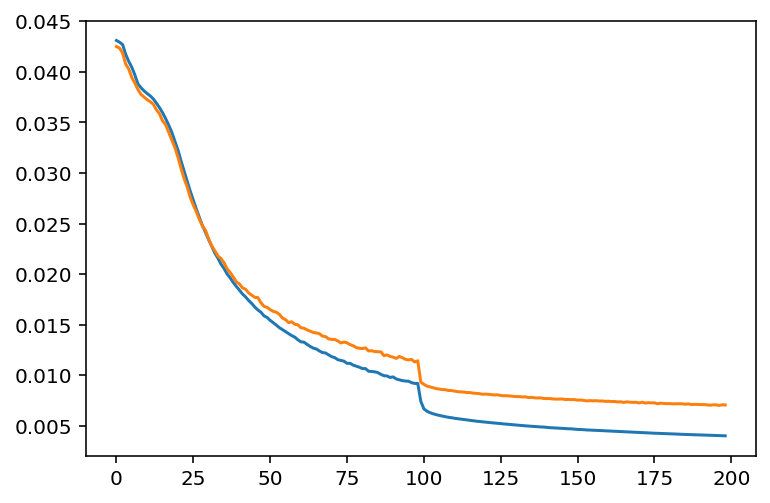

In [ ]:
loss = []
val_loss = []
val_acc = []
with open('/content/drive/MyDrive/KERAS_HISTORY/vaeBachC_vol_8CNN2.pkl', 'rb') as f:
    pkl = pickle.load(f)
    loss += pkl["loss"]
    val_loss += pkl["val_loss"]

for ctr in range(2,6):
  path = f"/content/drive/MyDrive/KERAS_HISTORY/vaeBachC{ctr}_vol_8CNN2.pkl"
  with open(path, 'rb') as f:
    pkl = pickle.load(f)
    loss += pkl["loss"]
    val_loss += pkl["val_loss"]

plt.plot(loss[1:])
plt.plot(val_loss[1:])

plt.show()


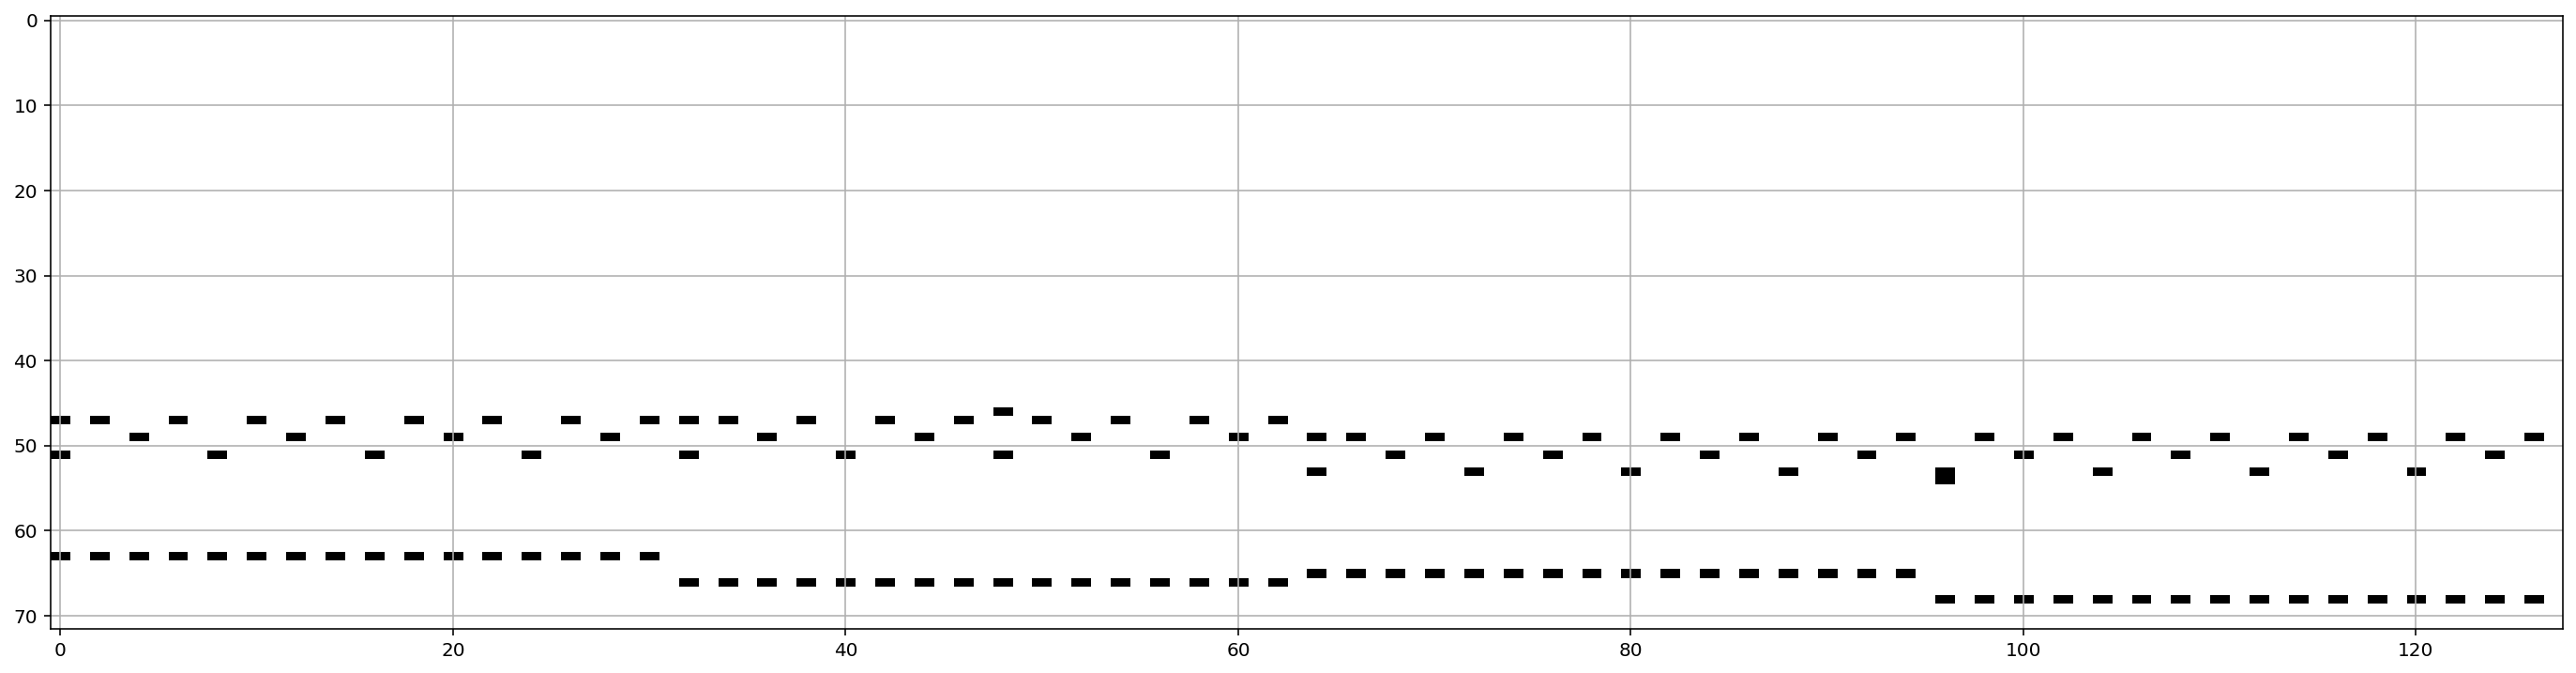

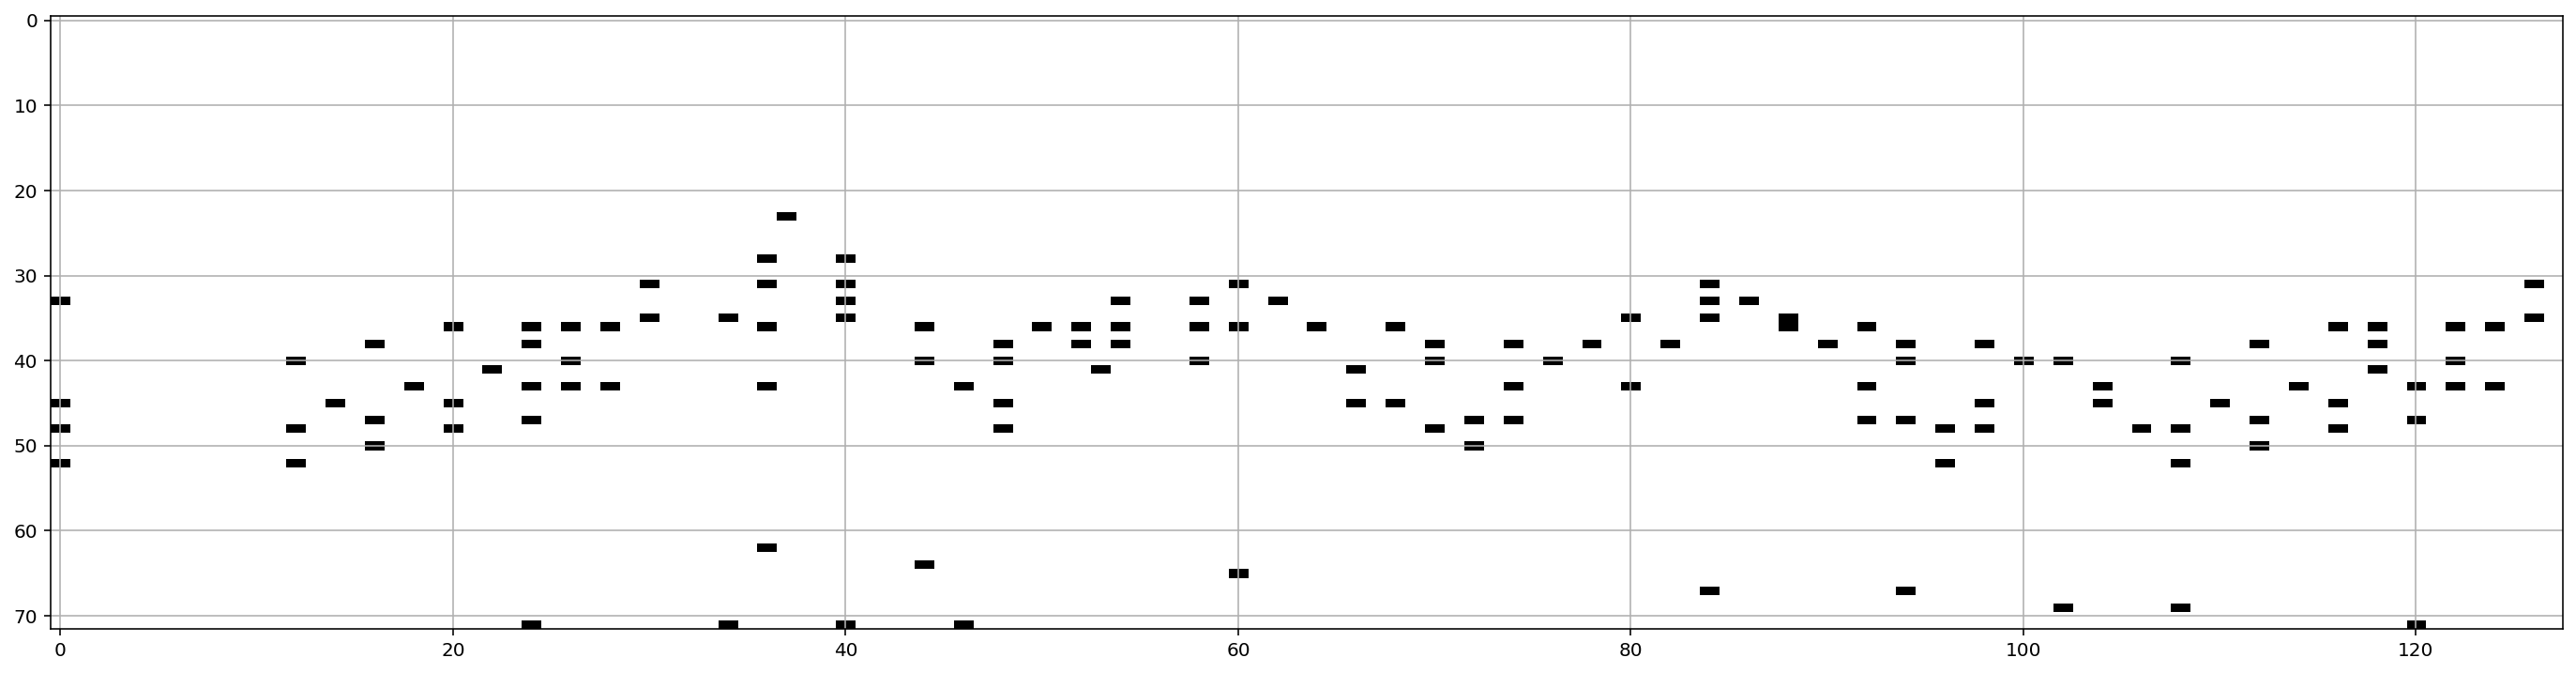

In [ ]:
INTERPOLATION_A = 9
INTERPOLATION_B = 15

plt.figure(figsize=(24, 6))
plt.imshow(np.flipud(x_train[INTERPOLATION_A].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

plt.figure(figsize=(24, 6))
plt.imshow(np.flipud(x_test[INTERPOLATION_B].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

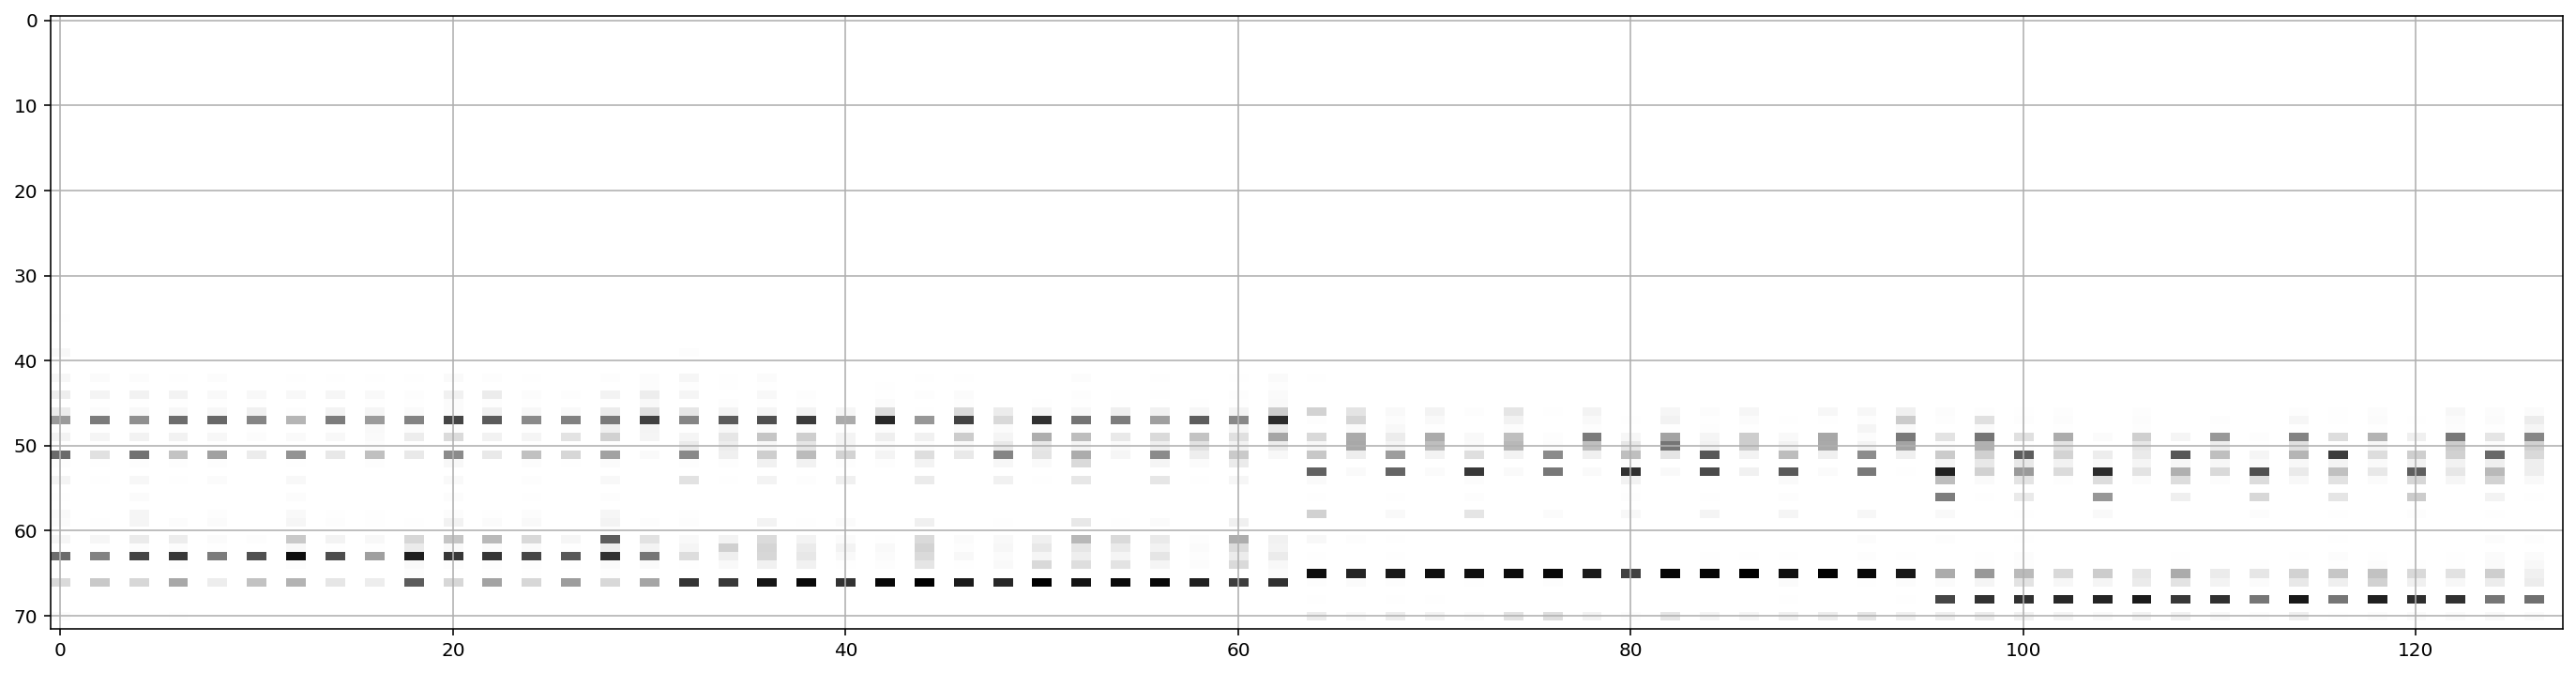

In [ ]:

_, _, z_vec_A = encoder.predict(x_train[INTERPOLATION_A].reshape([1,SEQ_LENGTH,72]))
_, _, z_vec_B = encoder.predict(x_test[INTERPOLATION_B].reshape([1,SEQ_LENGTH,72]))

## Transition

prediction_sum = np.round(decoder.predict(z_vec_A) + 0.2)


# for i in range(1,10,1):
#   ALPHA = i/10
#   z_vec_INTER = z_vec_A + (z_vec_B - z_vec_A)*ALPHA
#   interpolation_prediction = np.round(decoder.predict(z_vec_INTER)+.2)
#   test_pre = decoder.predict(z_vec_INTER)
#   plt.figure(figsize=(24, 6))
#   plt.title(ALPHA)
#   plt.imshow(np.flipud(interpolation_prediction[0].T), aspect='auto')
#   plt.set_cmap('gray_r')
#   plt.grid(True)

## Just one 

interpolation_prediction = (decoder.predict(z_vec_A)+.2)
#test_pre = decoder.predict(z_vec_INTER)
plt.figure(figsize=(24, 6))
plt.imshow(np.flipud(interpolation_prediction[0].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)


(1, 1, 72)


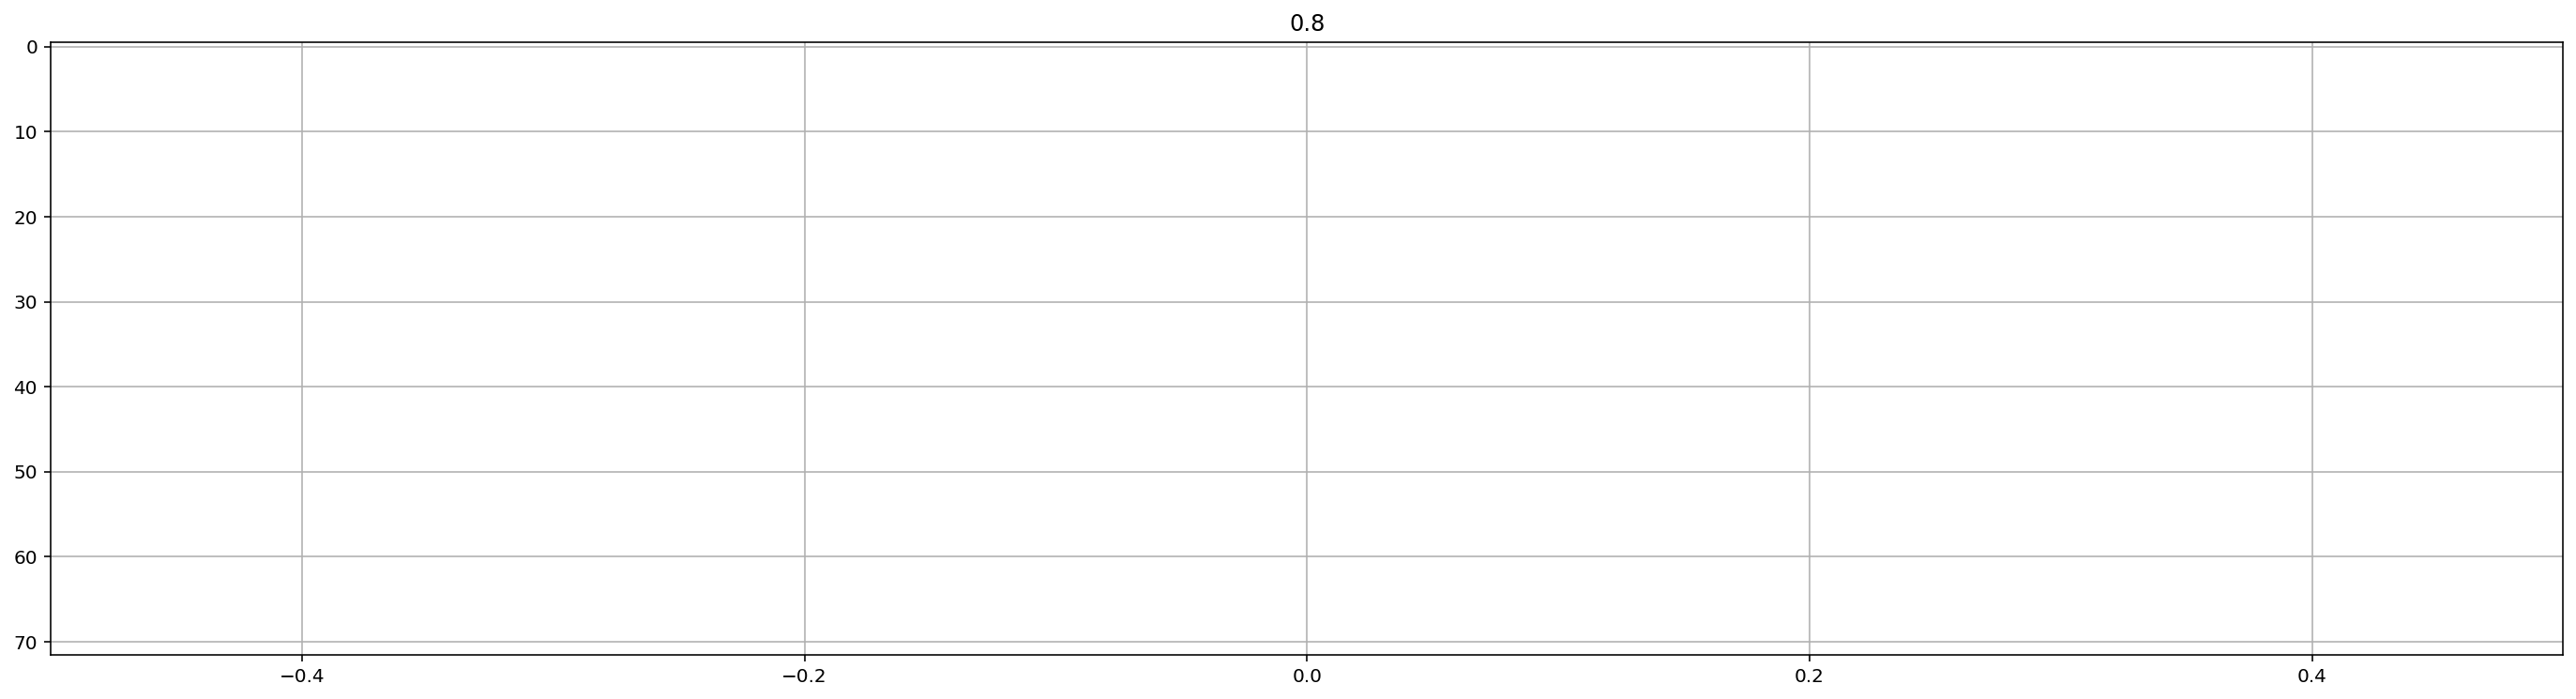

In [ ]:

_, _, z_vec_A = encoder.predict(x_test[INTERPOLATION_A].reshape([1,SEQ_LENGTH,72]))
_, _, z_vec_B = encoder.predict(x_test[INTERPOLATION_B].reshape([1,SEQ_LENGTH,72]))

## Transition

# prediction_sum = np.round(decoder.predict(z_vec_A) + 0.2)[:,192:]
prediction_sum = np.zeros(shape=(1,1,72))
for i in range(0,10,2):
  ALPHA = i/10
  z_vec_INTER = z_vec_A + (z_vec_B - z_vec_A)*ALPHA
  interpolation_prediction = np.round(decoder.predict(z_vec_INTER)+.2)[:,128:]


  prediction_sum = np.append(prediction_sum,interpolation_prediction,axis=1)
  #test_pre = decoder.predict(z_vec_INTER)
  # plt.figure(figsize=(24, 6))
  # plt.title(ALPHA)
  # plt.imshow(np.flipud(interpolation_prediction[0].T), aspect='auto')
  # plt.set_cmap('gray_r')
  # plt.grid(True)
print(prediction_sum.shape)
plt.figure(figsize=(24, 6))
plt.title(ALPHA)
plt.imshow(np.flipud(prediction_sum[0].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Just one 

# ALPHA = 0.7
# z_vec_INTER = z_vec_A + (z_vec_B - z_vec_A)*ALPHA
# interpolation_prediction = np.round(decoder.predict(z_vec_INTER)+.2)
# #test_pre = decoder.predict(z_vec_INTER)
# plt.figure(figsize=(24, 6))
# plt.imshow(np.flipud(interpolation_prediction[0].T), aspect='auto')
# plt.set_cmap('gray_r')
# plt.grid(True)


In [ ]:
generate_midi_song(prediction_sum[0])
!fluidsynth -ni font.sf2 this.mid -F output.wav -r 44100
Audio('output.wav')

In [ ]:
mu, sig, z_vec = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))

z_test = np.random.randn(1,1451)

# for i in range(20):
#   plt.scatter(mu[:, 0], mu[:, i], c=x_test[:,45,0], cmap='brg')
#   plt.axis([-5, 5, -5, 5])

#   plt.xlabel('dim 1')
#   plt.ylabel('dim 2')
#   plt.colorbar()
#   plt.show()

y = np.linspace(-2,2,num=z_vec.shape[0])
for i in range(10):

  plt.scatter(z_vec[:, i],y, cmap='brg')
  plt.axis([-1, 1, -1, 1])

  plt.xlabel('dim 1')
  plt.ylabel('dim 2')
  plt.colorbar()
  plt.show()

#identity = np.identity(NUMBER_OF_NOTES)

# plt.plot(mu[:,0],mu[:,4],'ro')
# plt.show()

# for i in range(20):
#     plt.scatter(mu[:,0], mu[:,i], c=x_test[:,sequence_length//2,0], cmap='plasma')

#plt.axis([-3, 3, -3, 3])

plt.show()

np.set_printoptions(threshold=sys.maxsize)
#predicted = vae.predict(x_train)

new_song_vector = np.random.rand(1,128)

from scipy.special import expit

new_song_vector = expit(new_song_vector)


#print(new_song_vector)

#sample_vec = np.array([[0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2,0.1,0.2]])

gg = z_vec[0]
gg = gg.reshape(1,latent_dim)
predicted = decoder.predict(gg)


print(len(mu))
print(len(sig))
print(len(z_vec))


#print(mu[4,:])
#print(predicted)

*def* sample_z(args):

  z_mean, z_sigma = args
  
  eps = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]),mean=0.0,stddev=0.001)

  return z_mean + K.exp(z_sigma * 0.5) * eps


In [ ]:
print(enc_z.shape)
print(dec_pre.shape)

(28028, 256)
(28028, 256, 72)


In [ ]:
test_pre =decoder.predict(z_vec[:1024])

In [ ]:
INDEX = 13

plt.figure(figsize=(24, 6))
plt.imshow(np.flipud(x_test[INDEX].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

plt.figure(figsize=(24, 6))
plt.imshow(np.flipud(test_pre[INDEX].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)


In [ ]:
INDEX = 128
plt.figure(figsize=(24, 6))
plt.imshow(np.flipud(x_train[INDEX].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

plt.figure(figsize=(24, 6))
plt.imshow(np.flipud(dec_pre[INDEX].T), aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

In [ ]:
rand_vecs = np.random.normal(0,.95 ,size=(20,latent_dim))
y_song = decoder.predict(rand_vecs)


In [ ]:
A = 0.9
y_song_rounded = np.round(y_song - A + 0.5)


In [ ]:
y_song_rounded = y_song

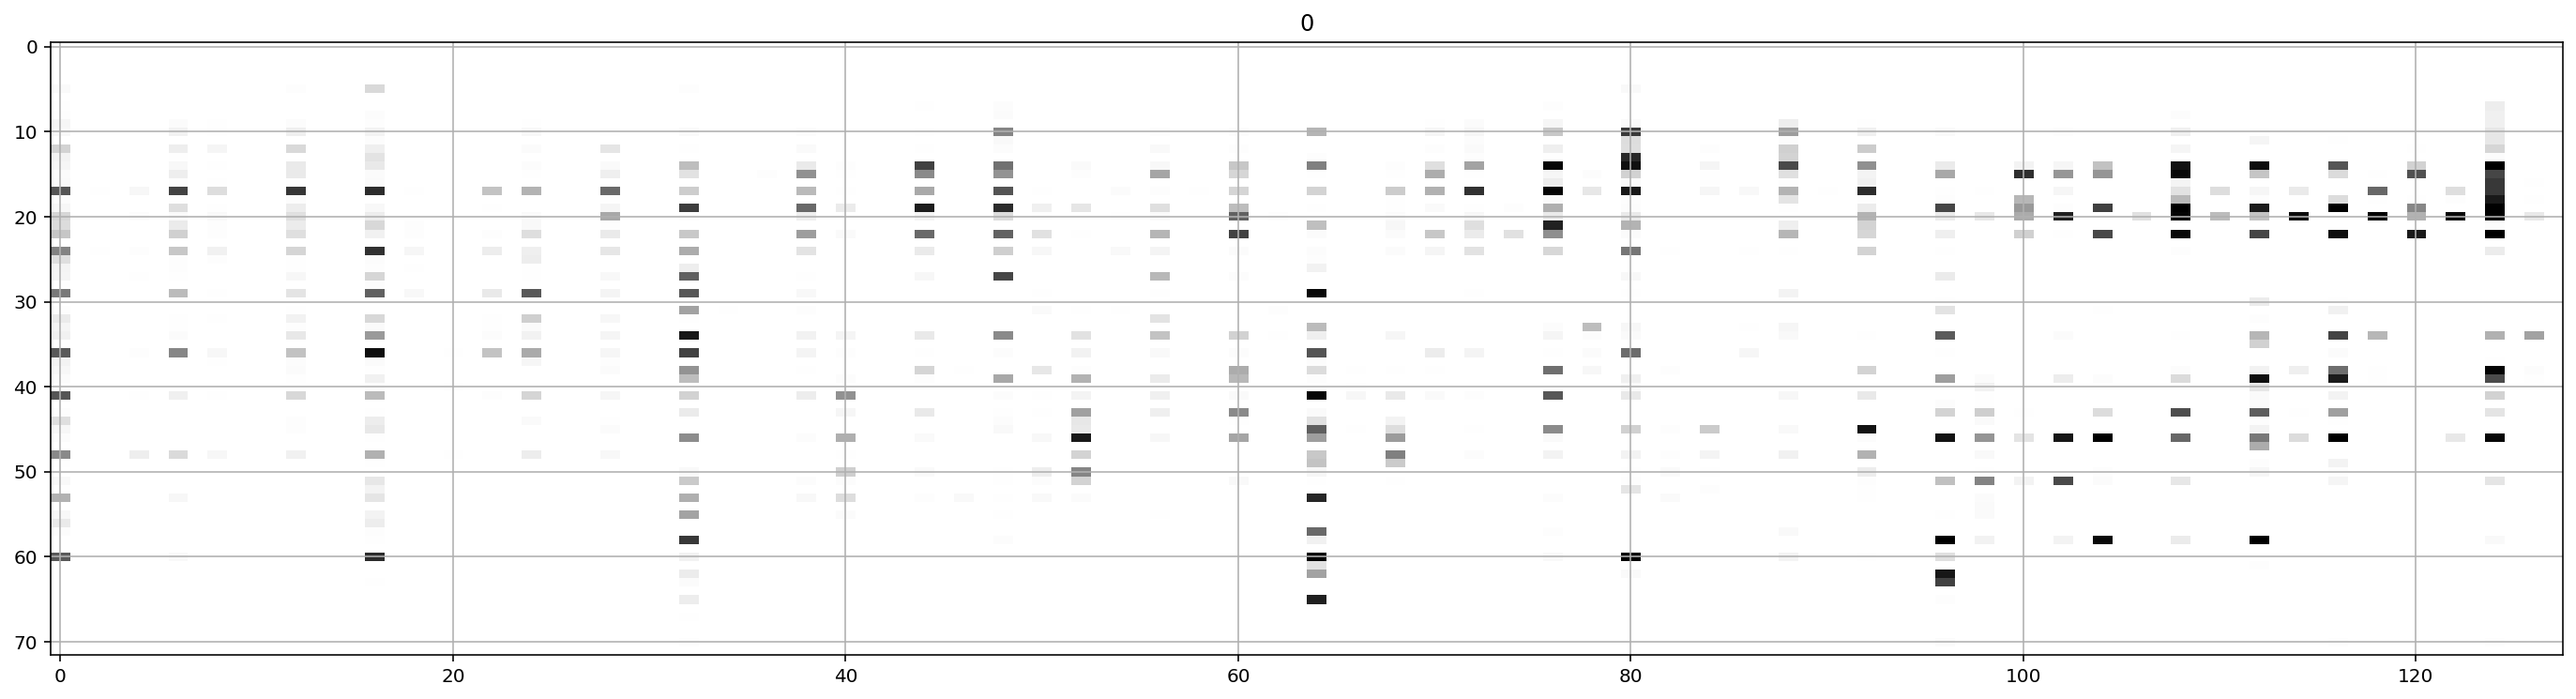

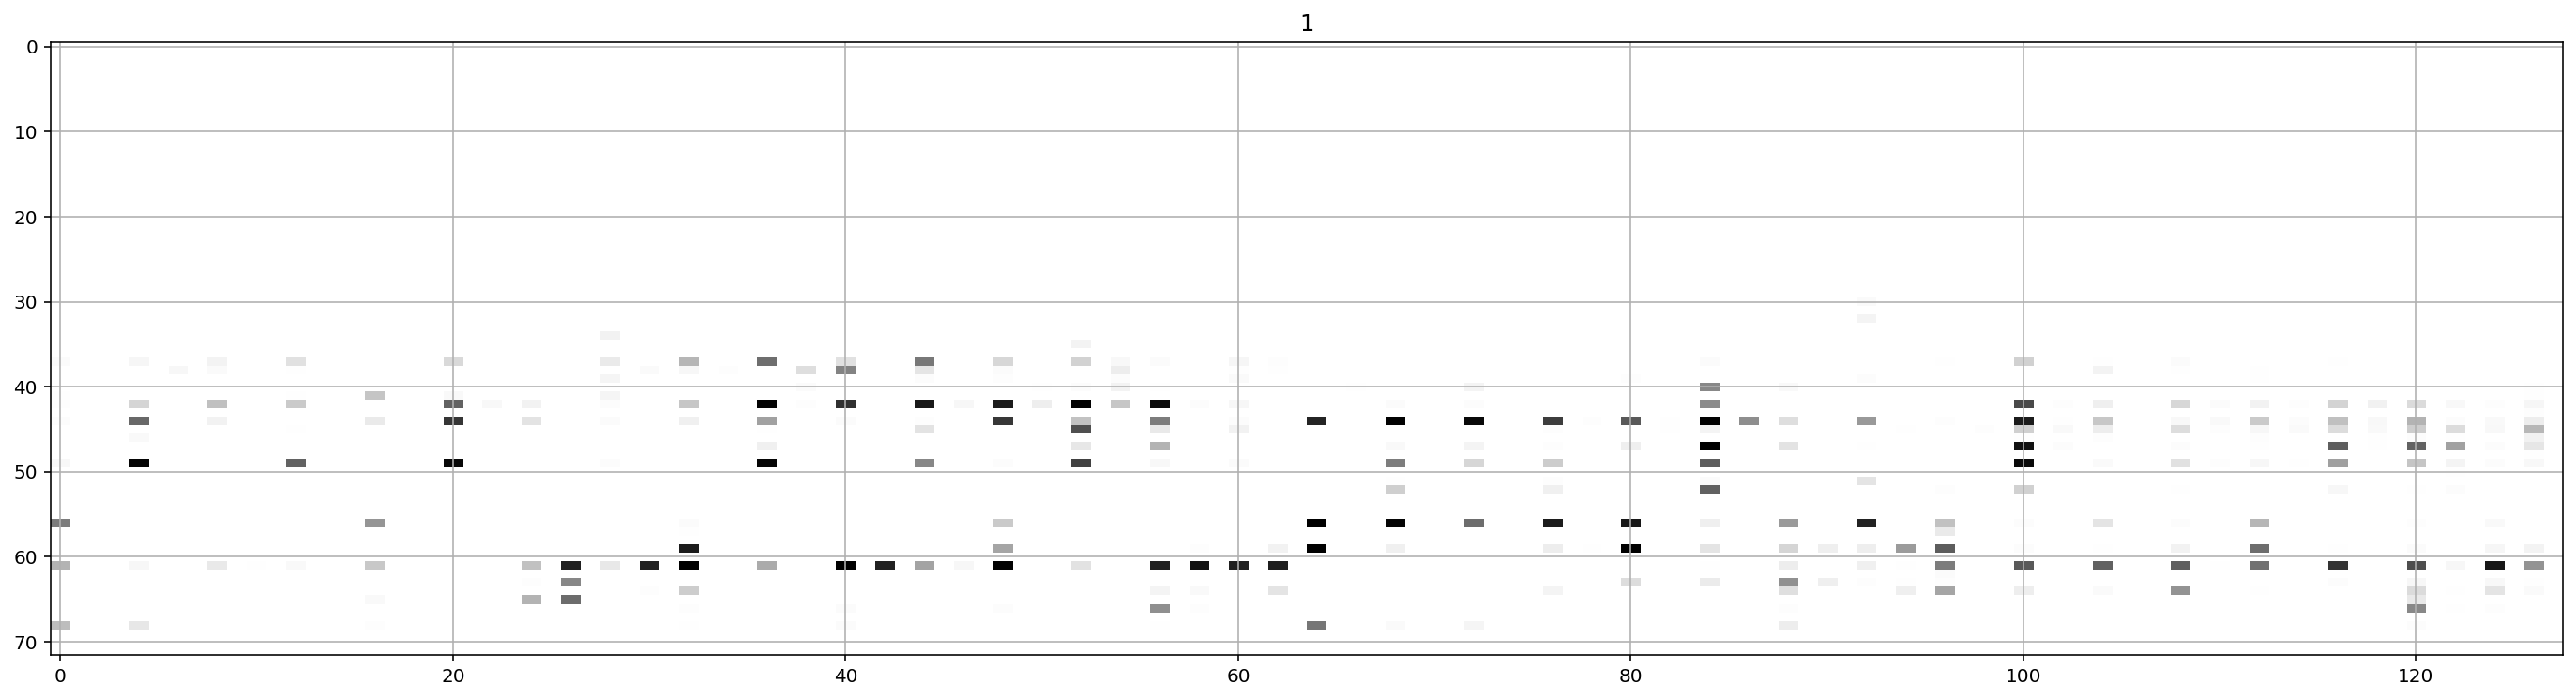

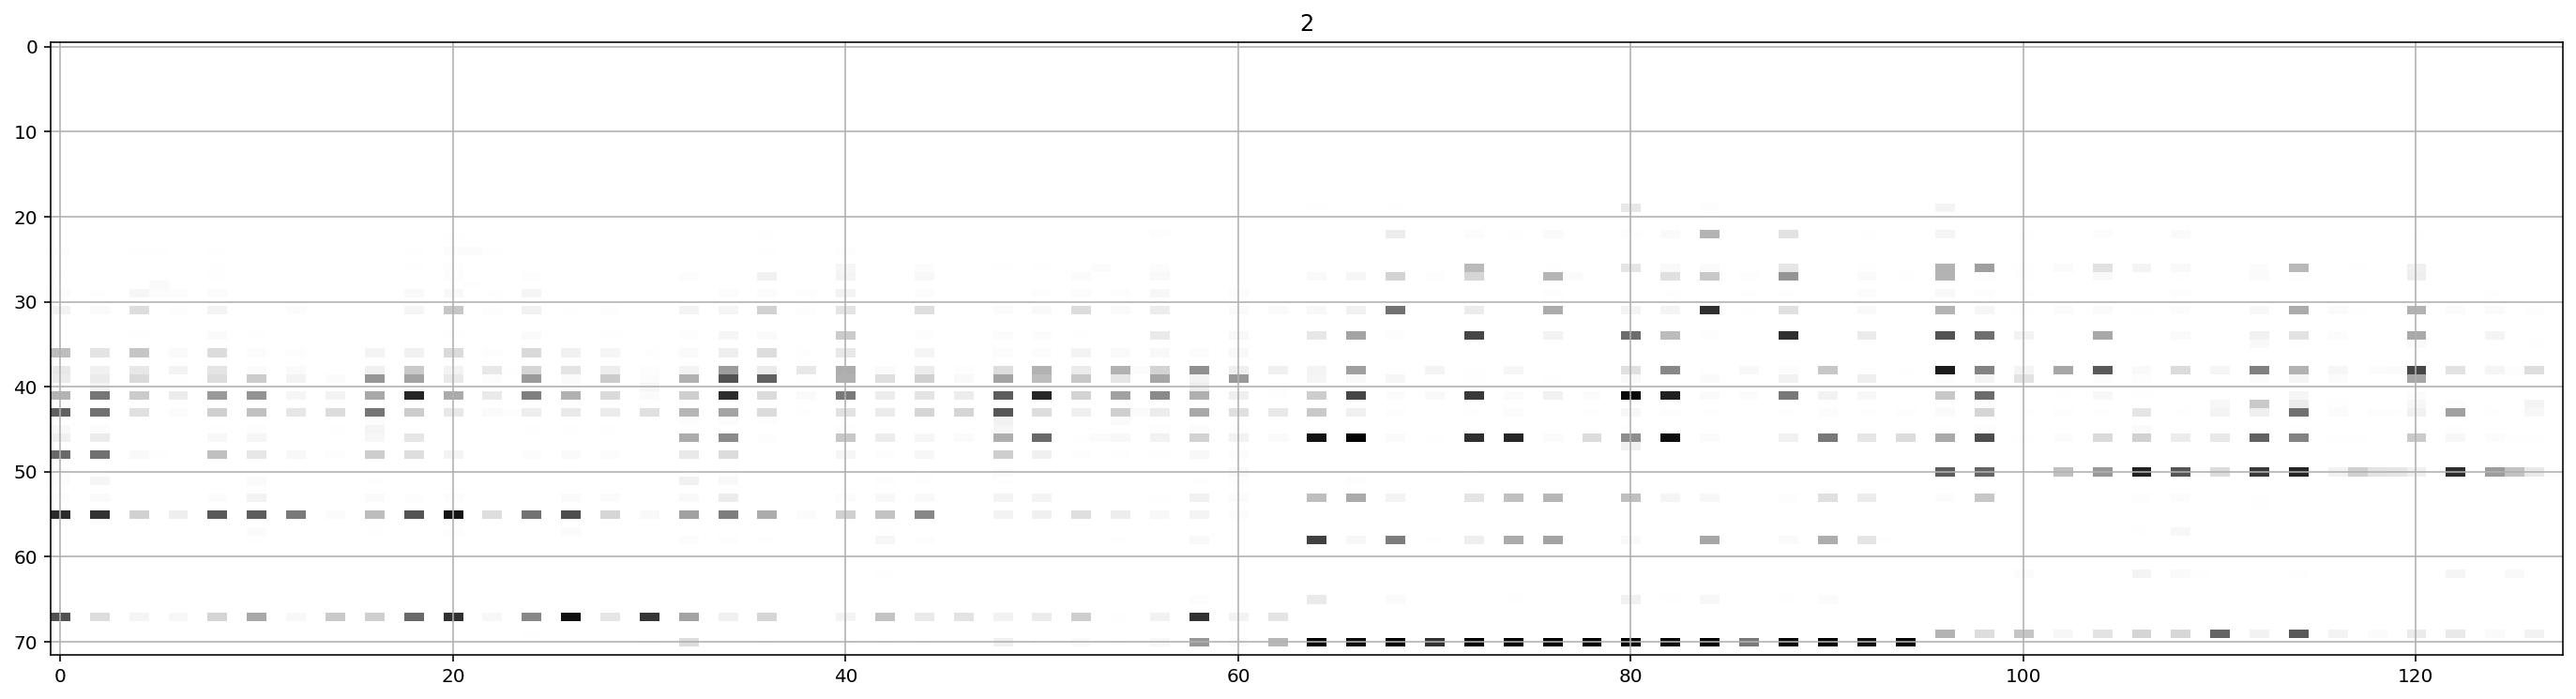

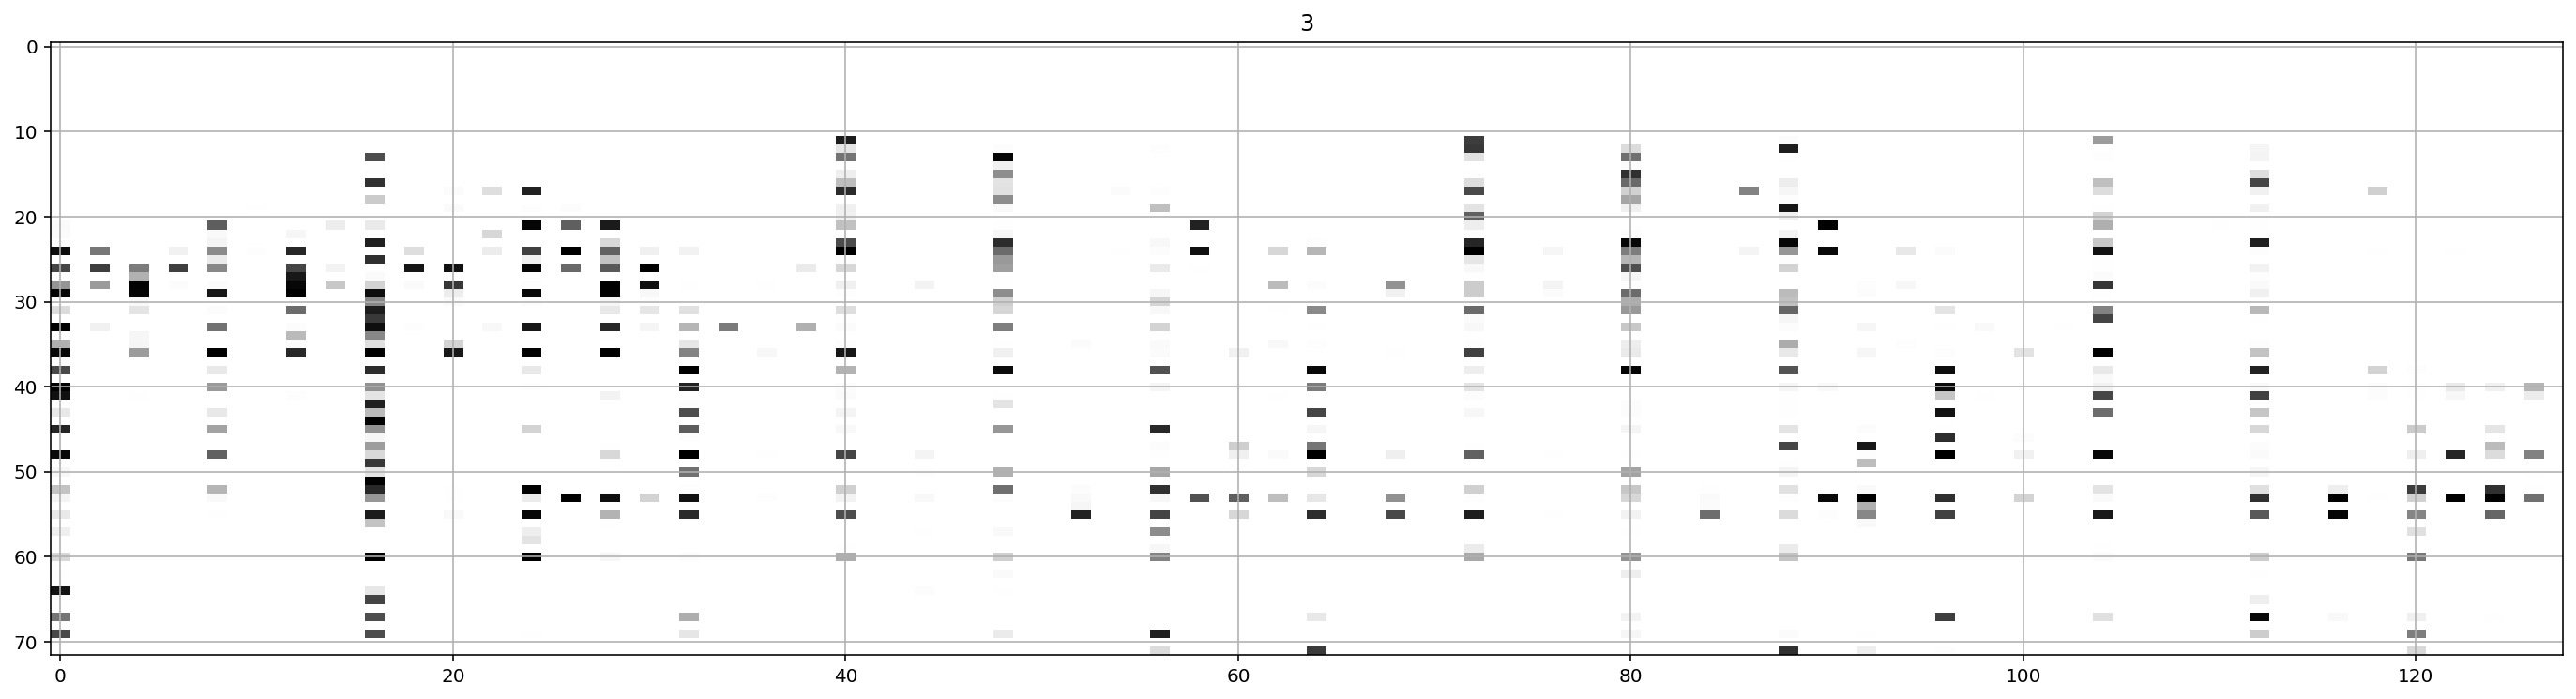

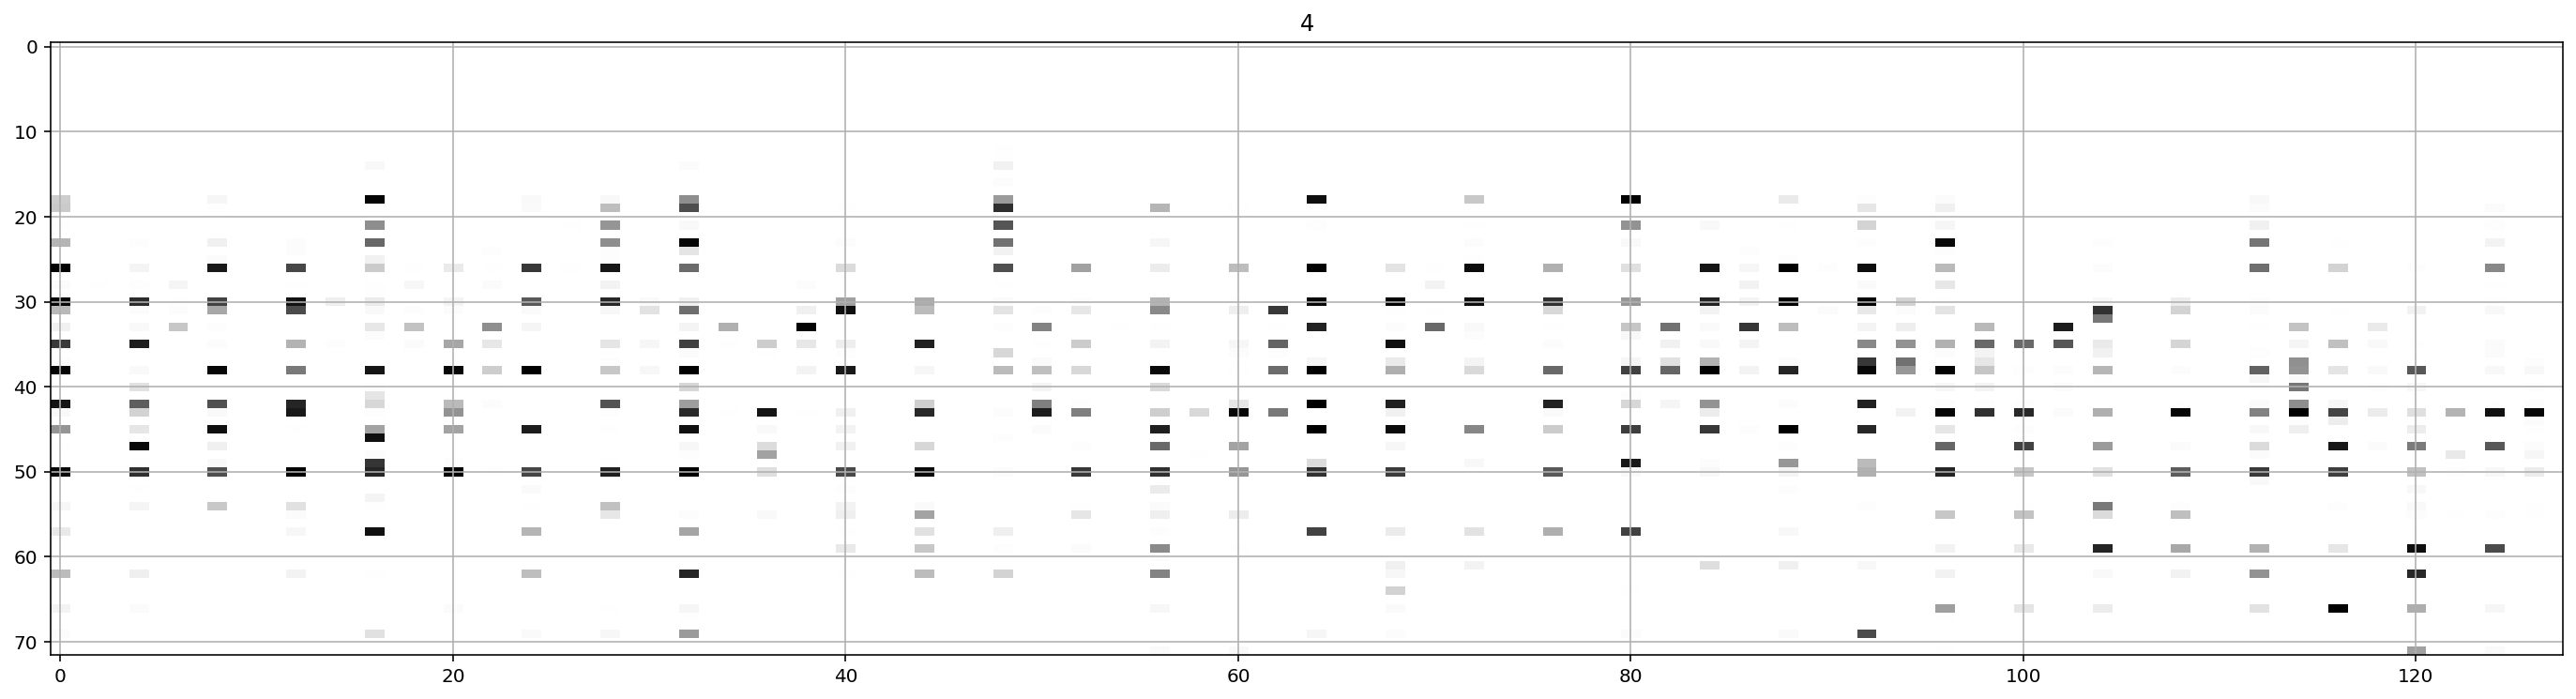

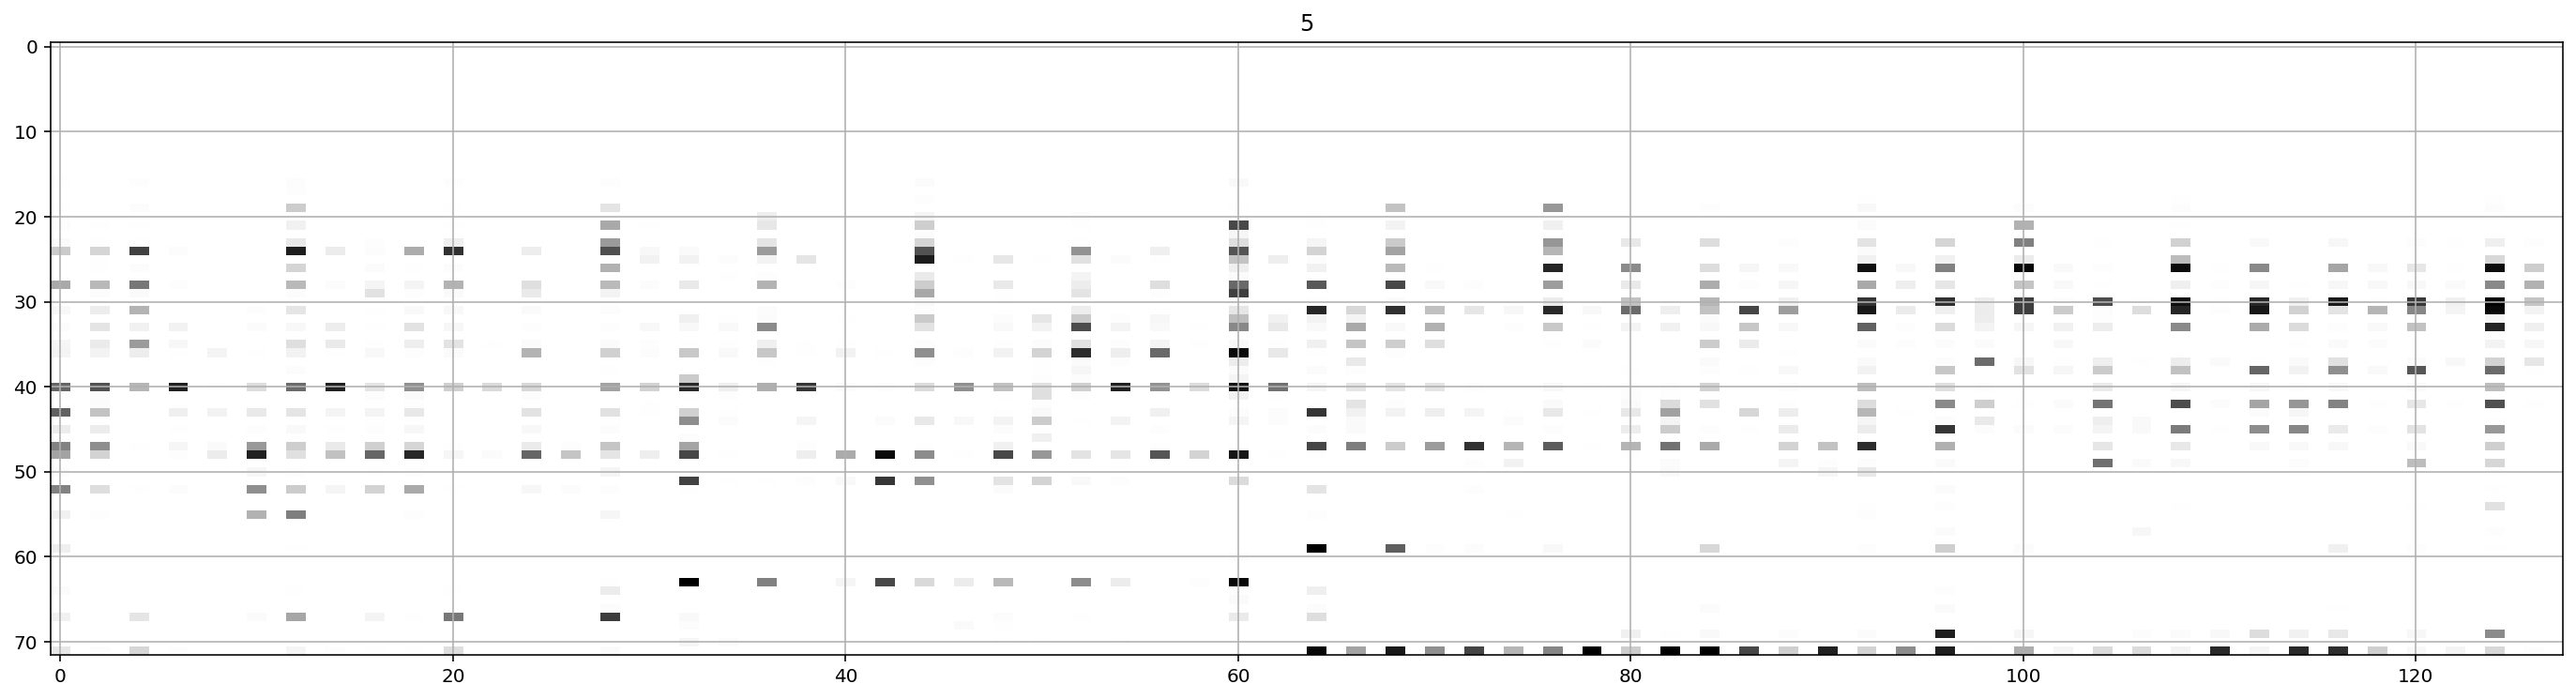

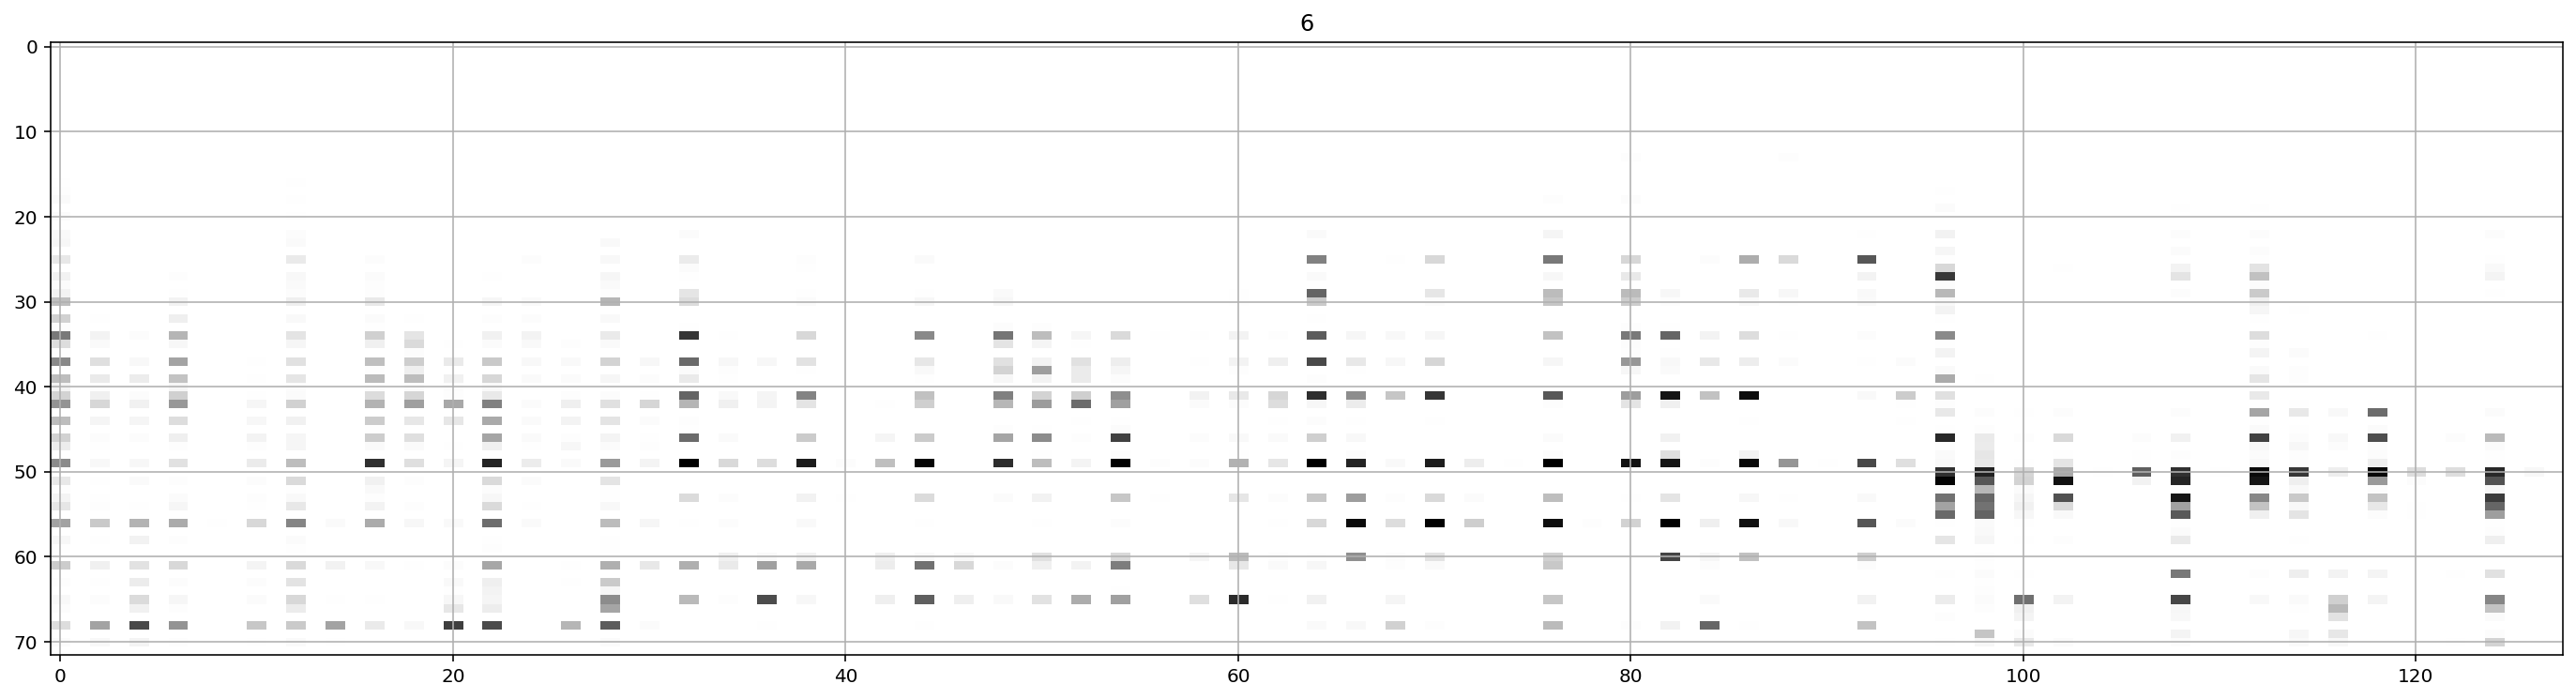

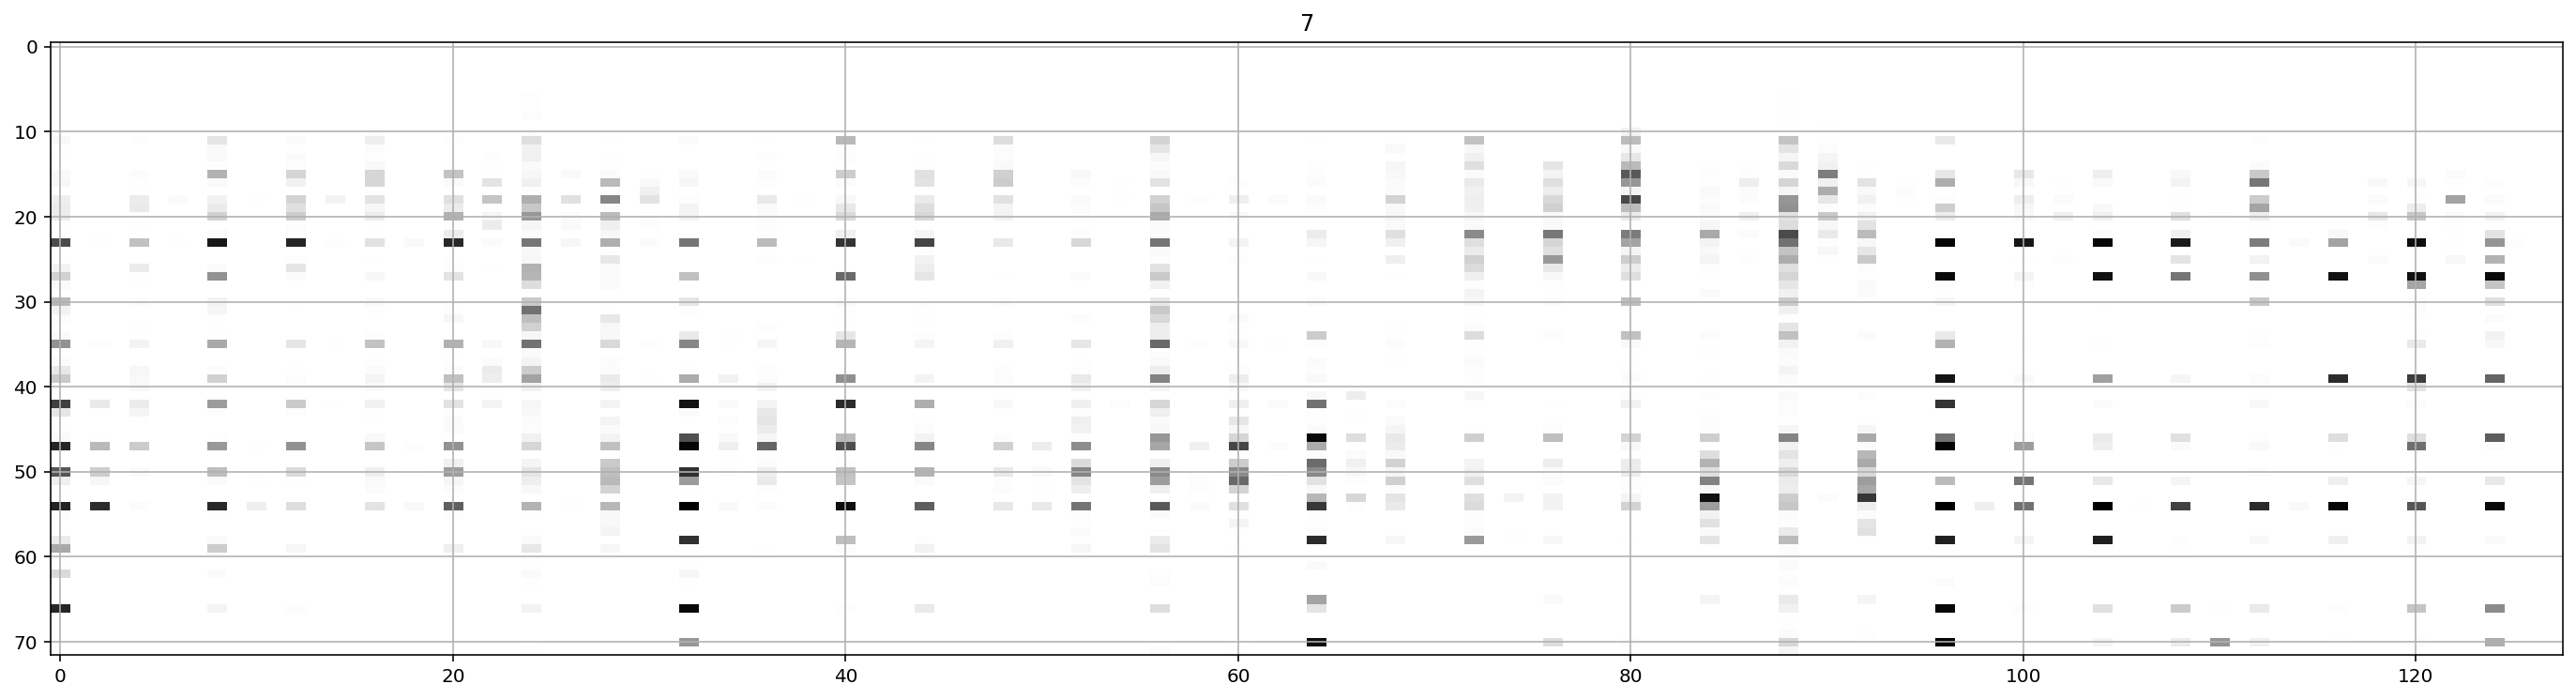

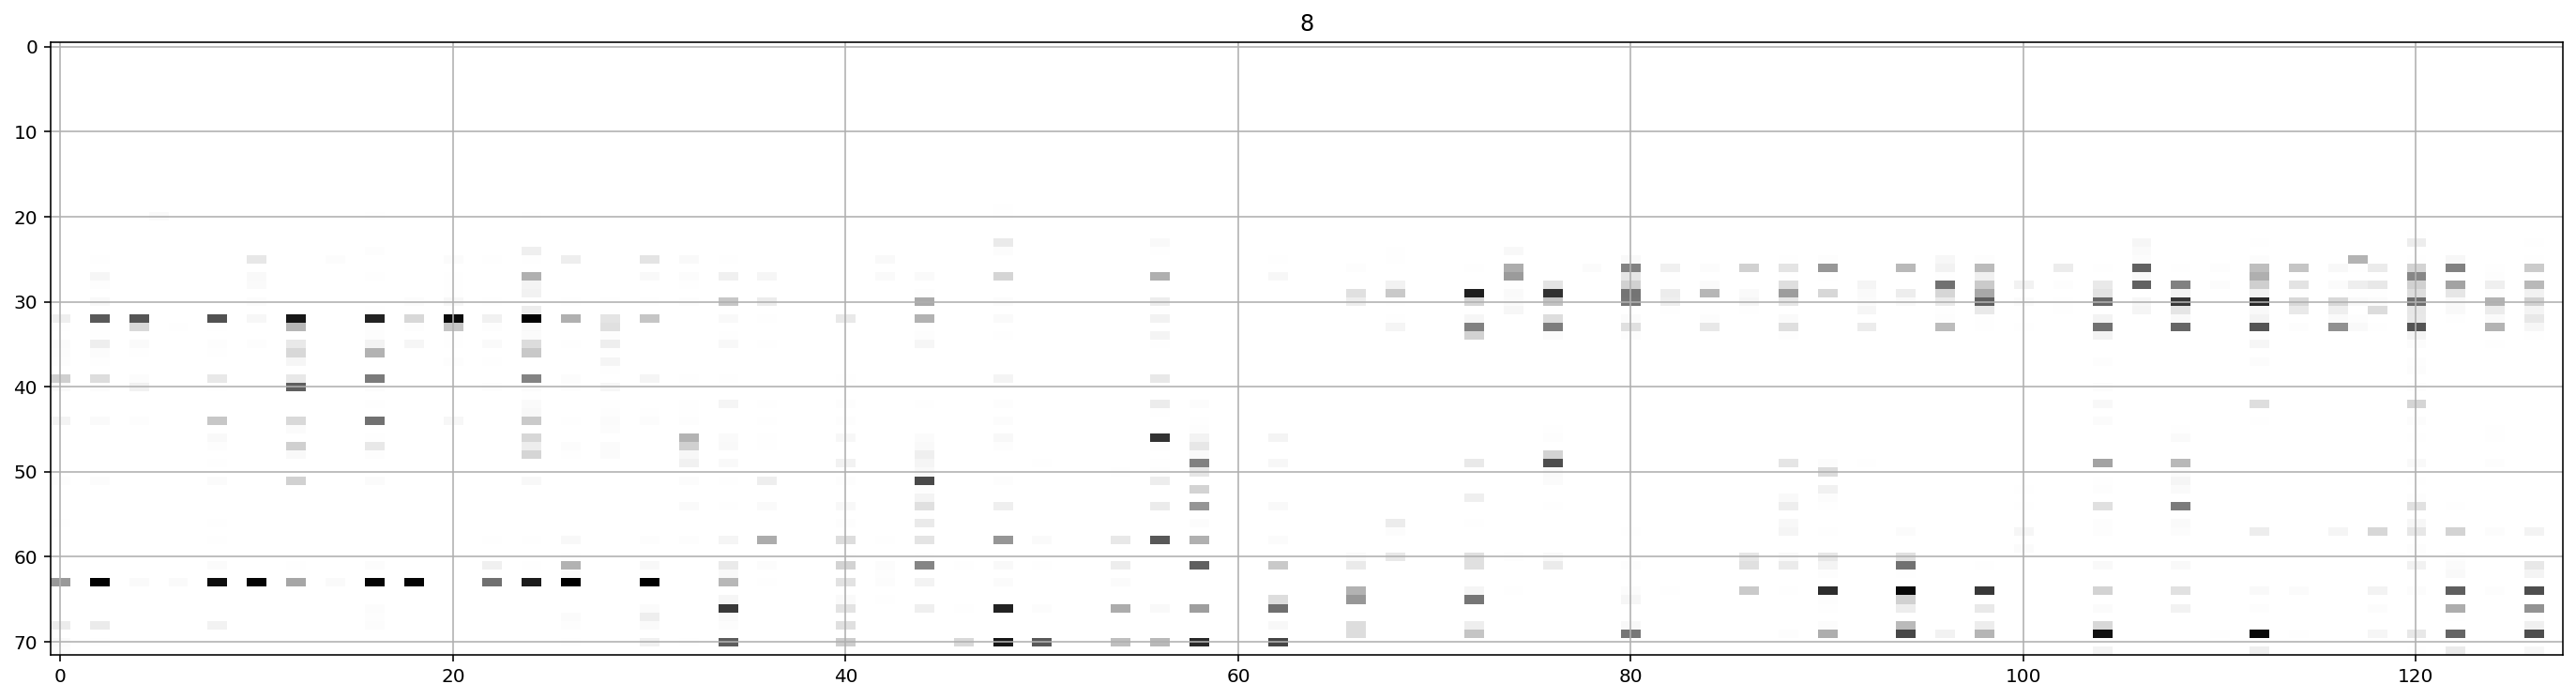

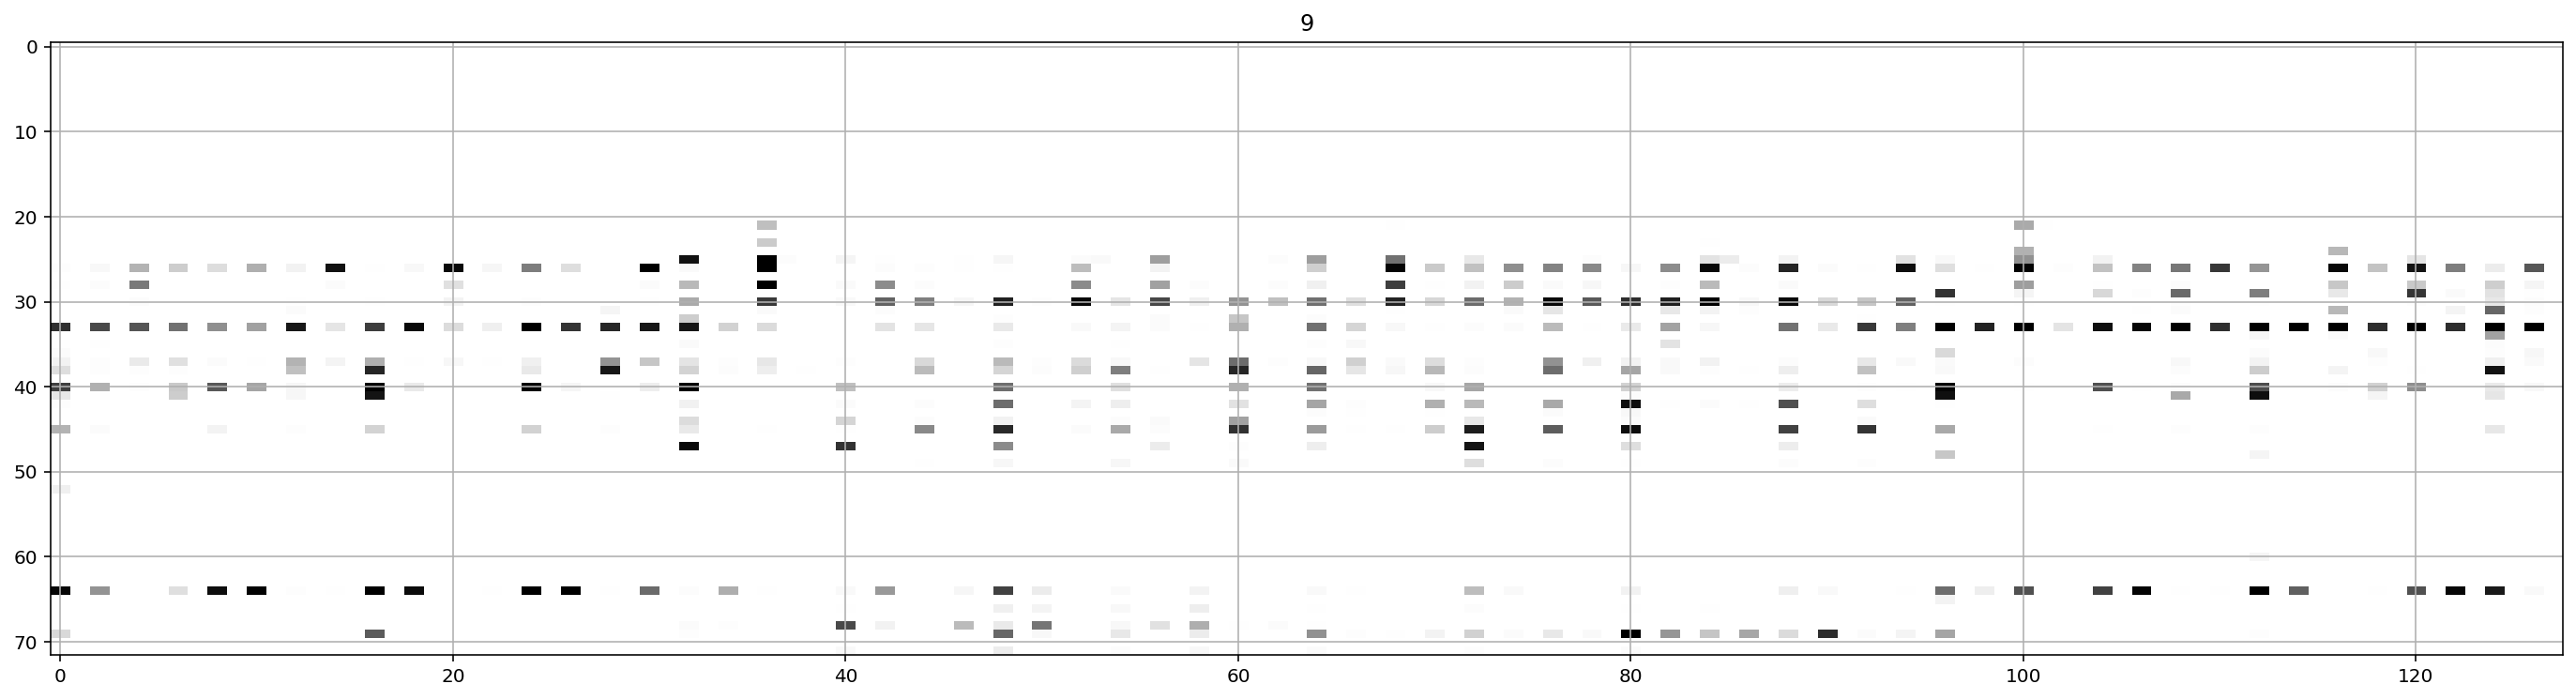

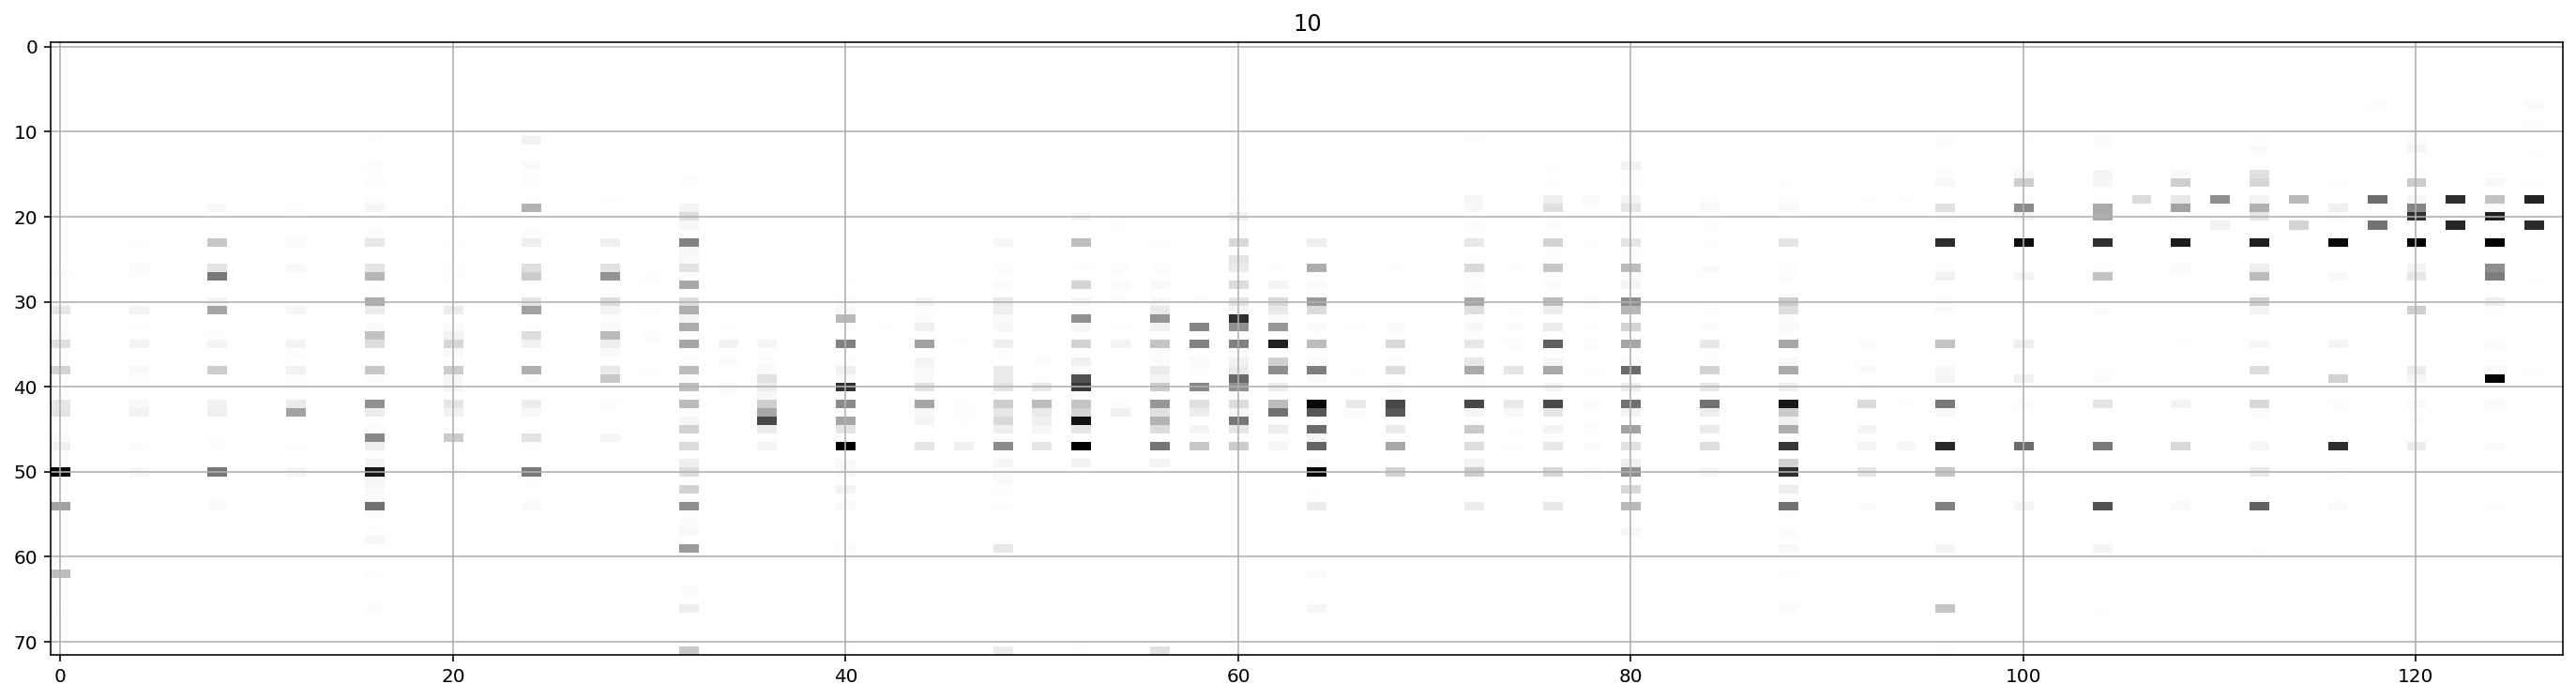

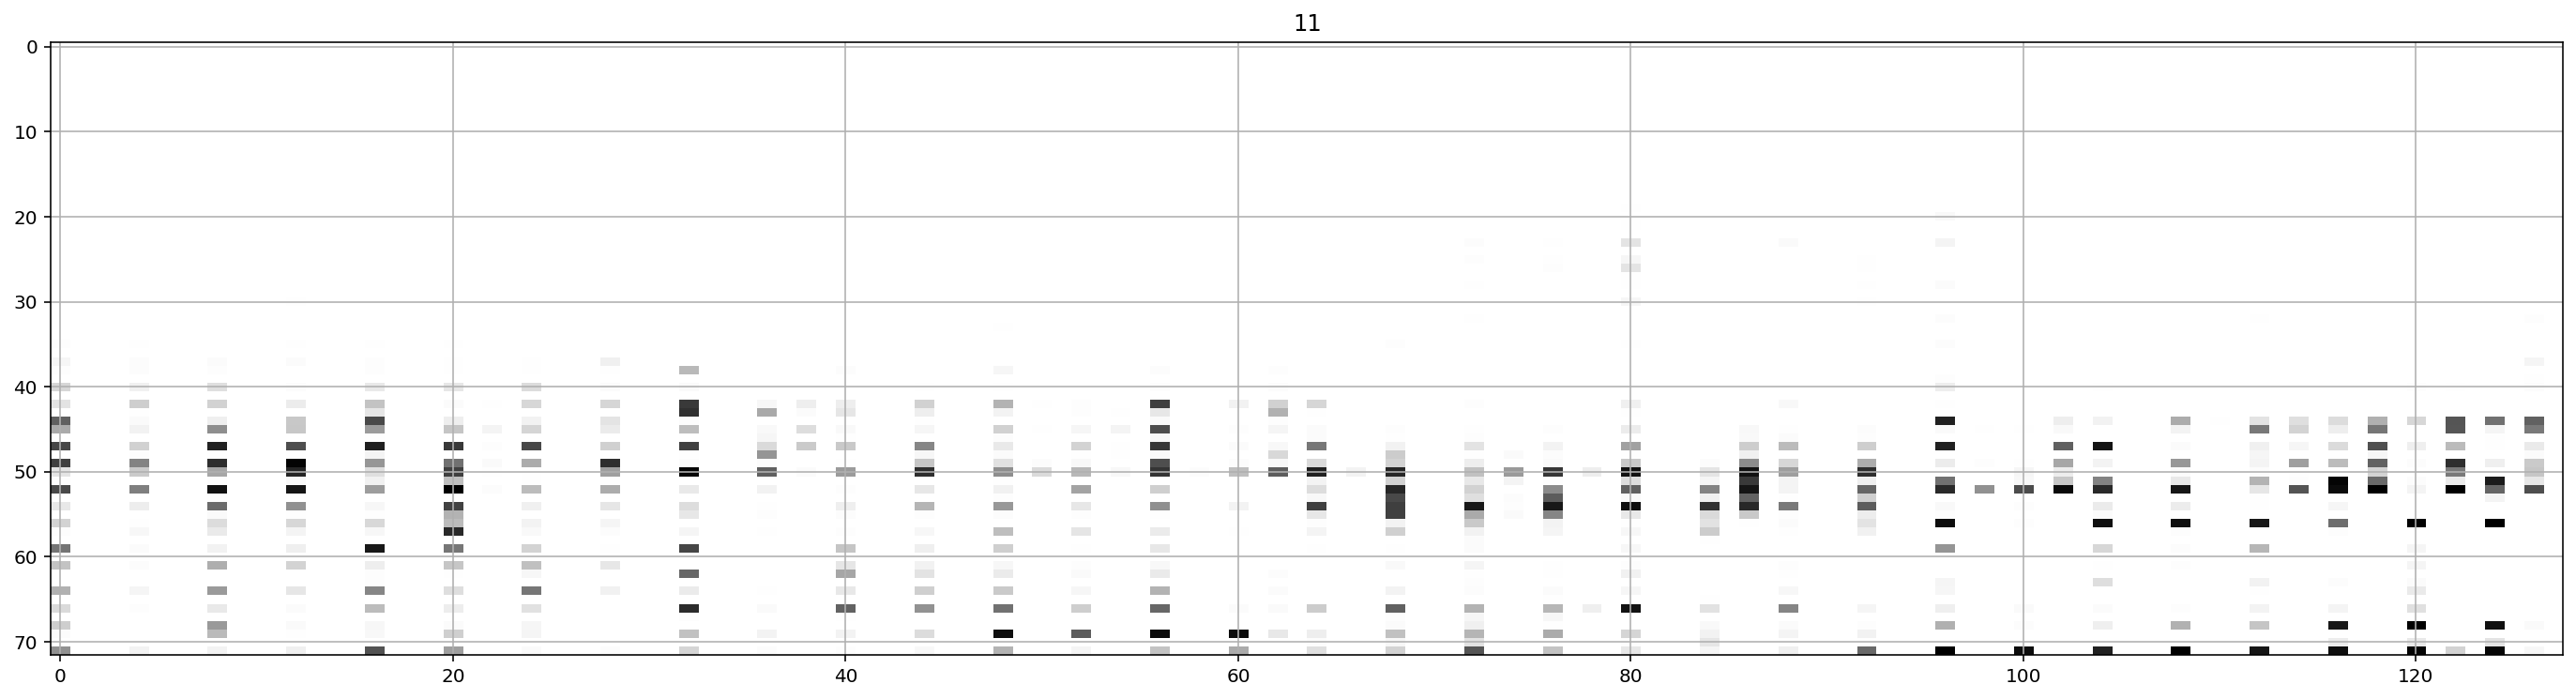

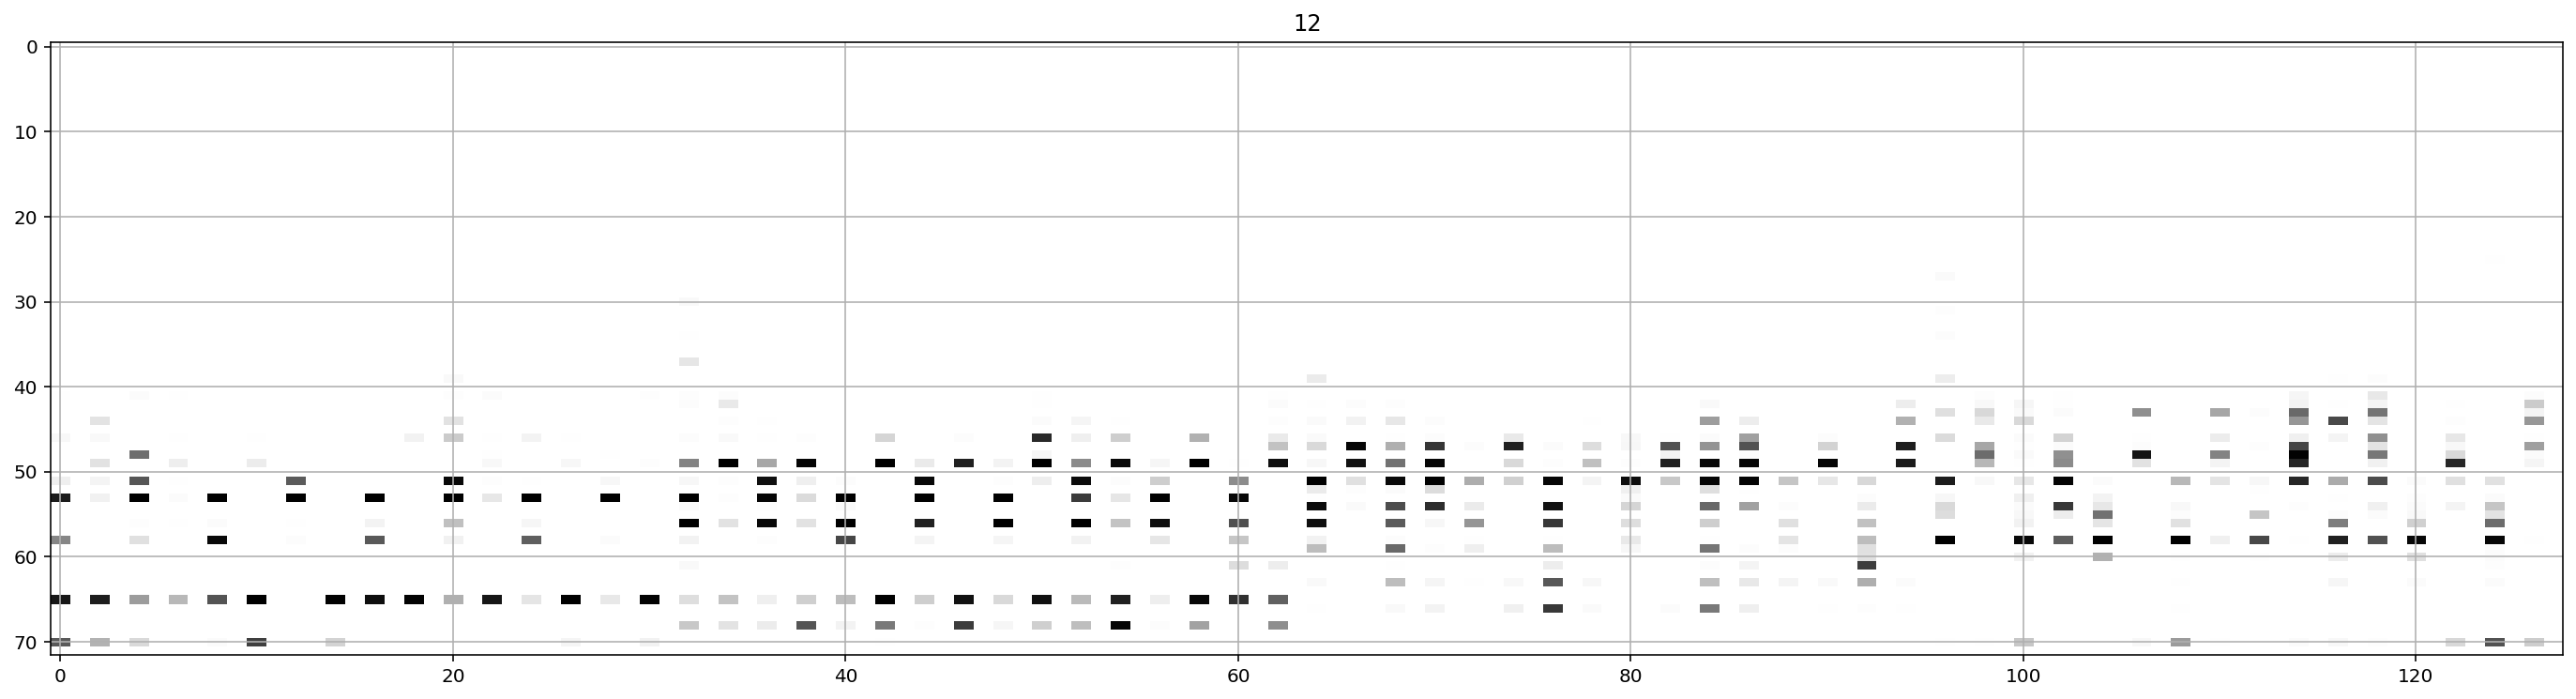

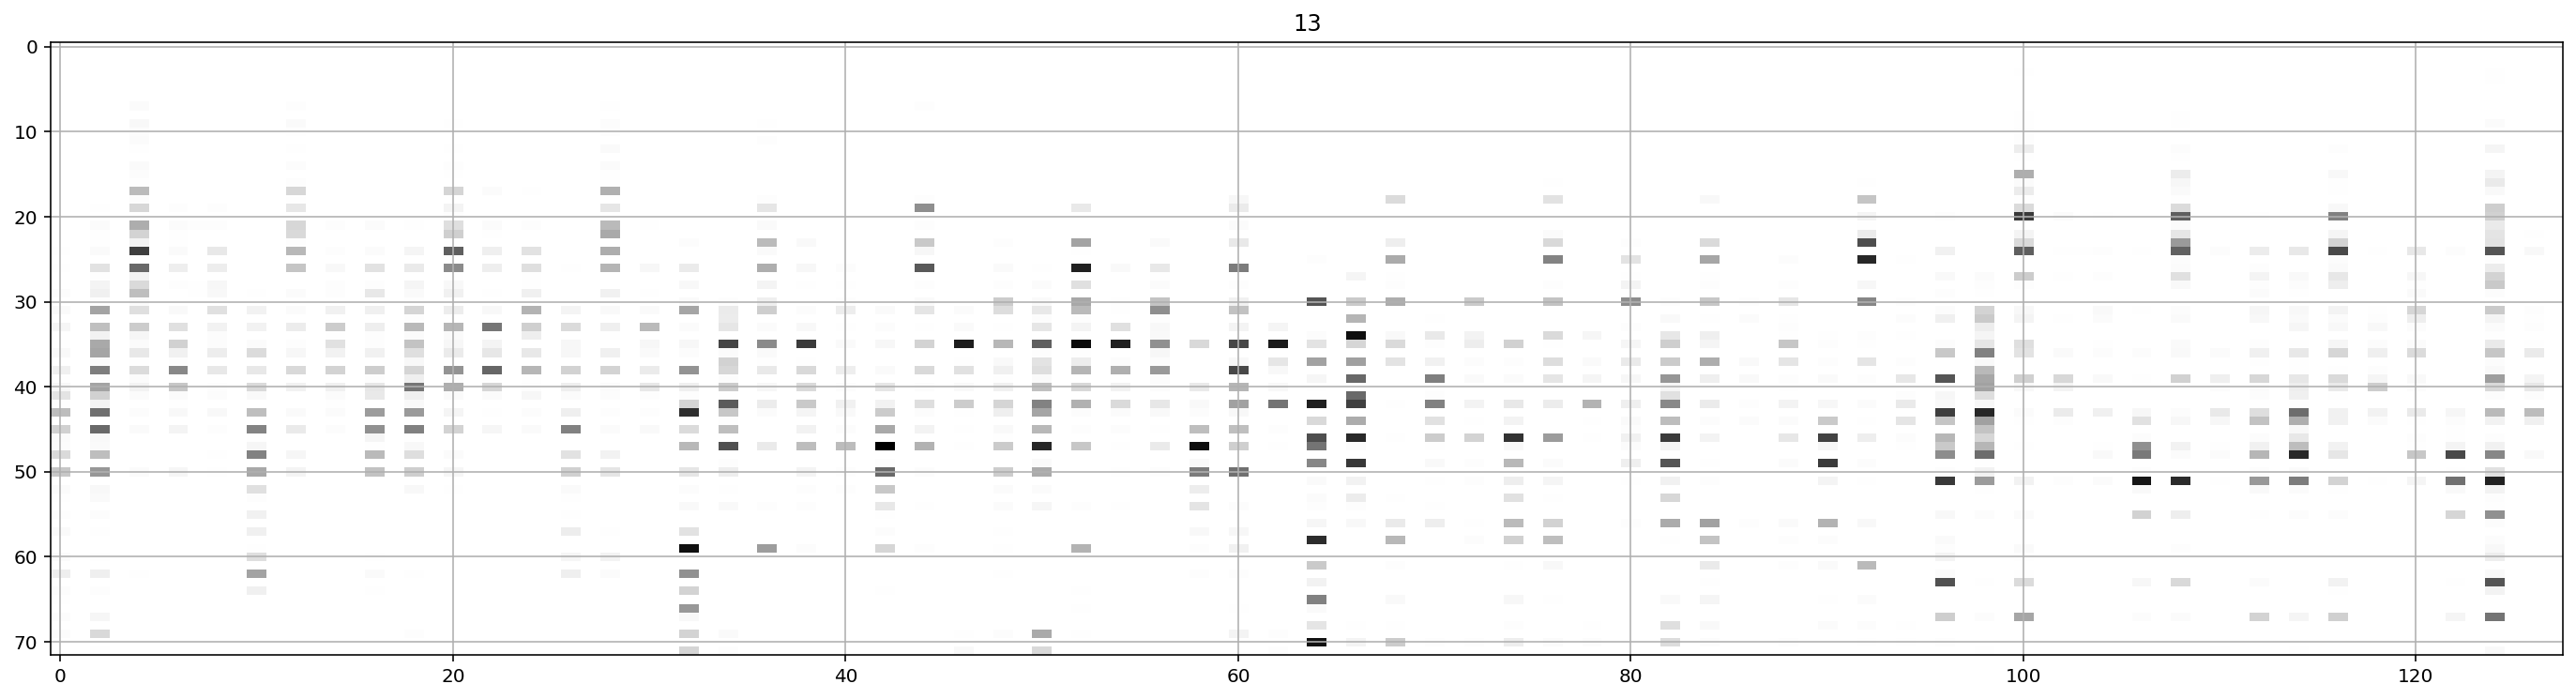

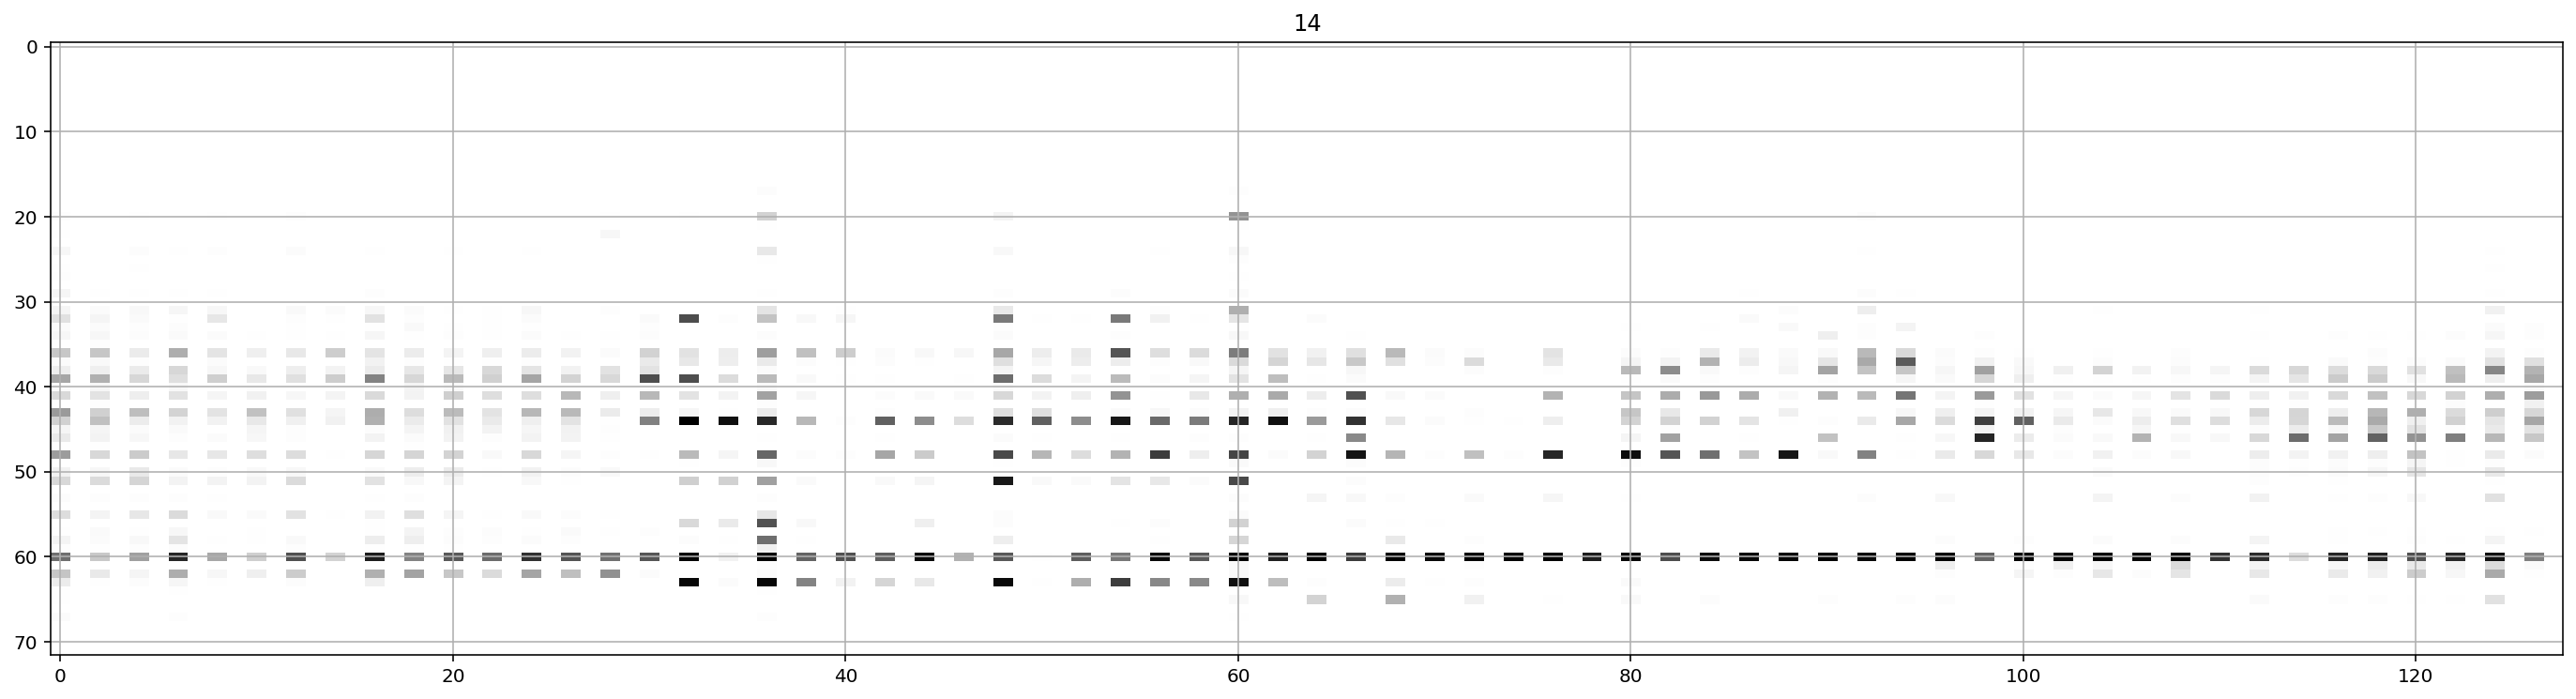

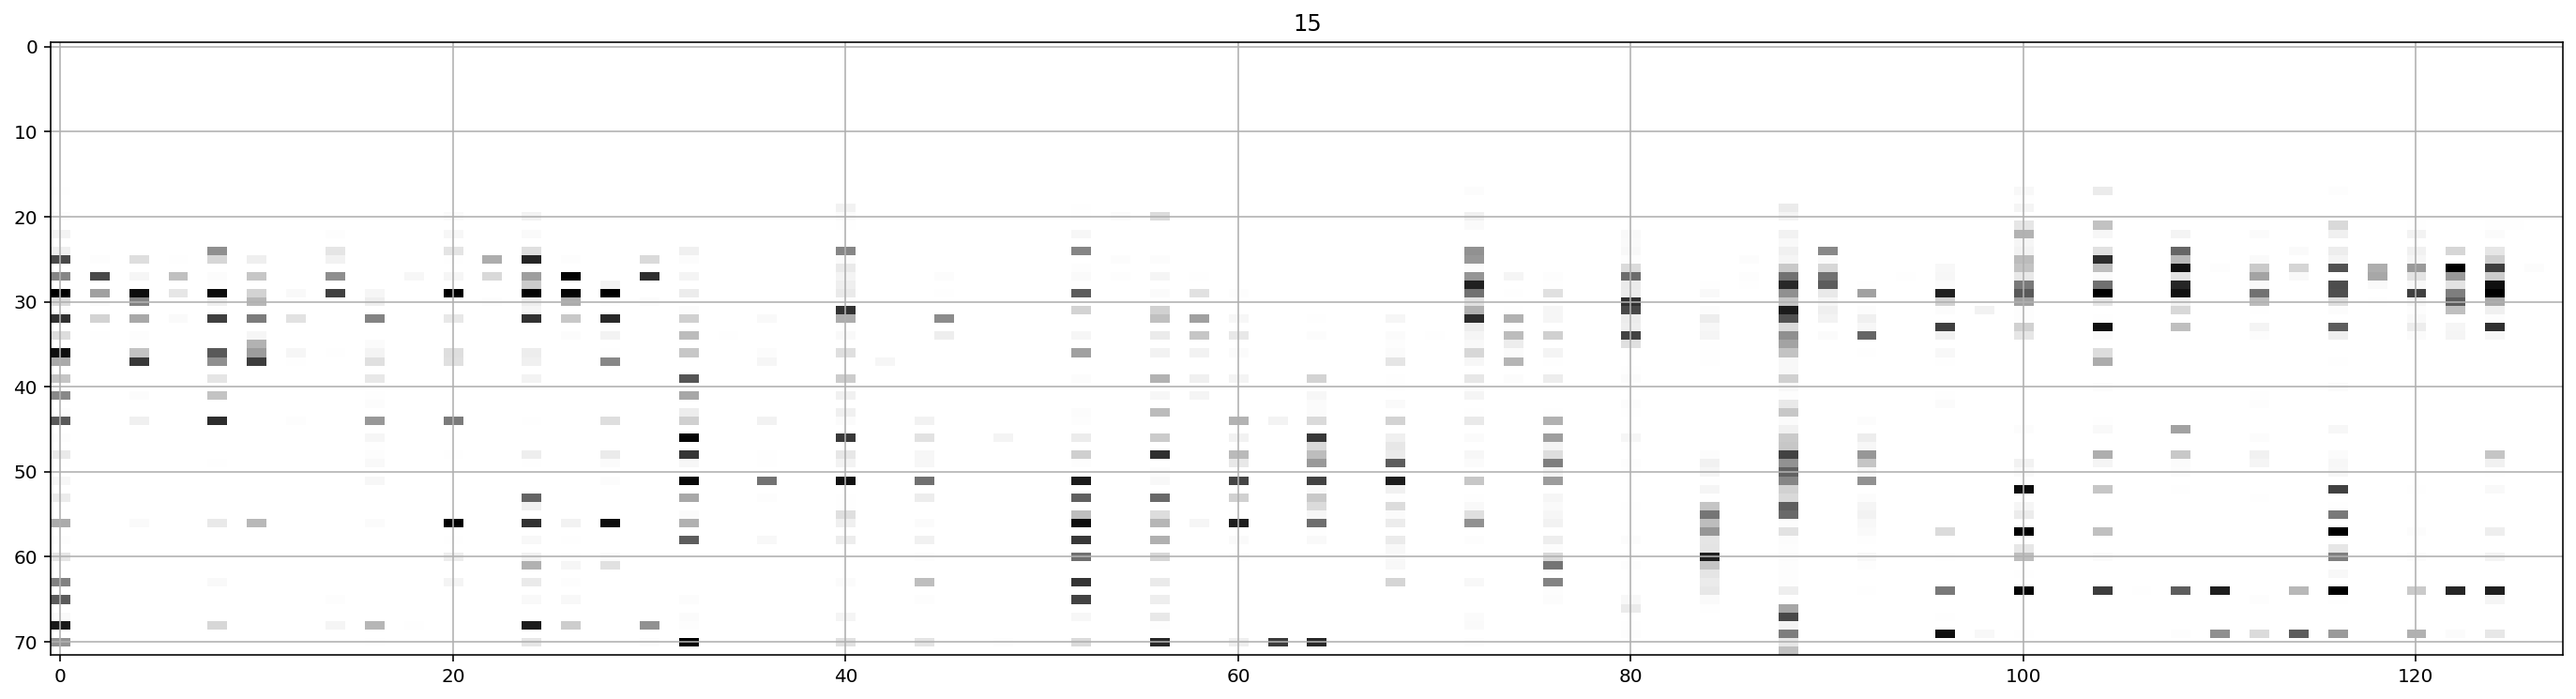

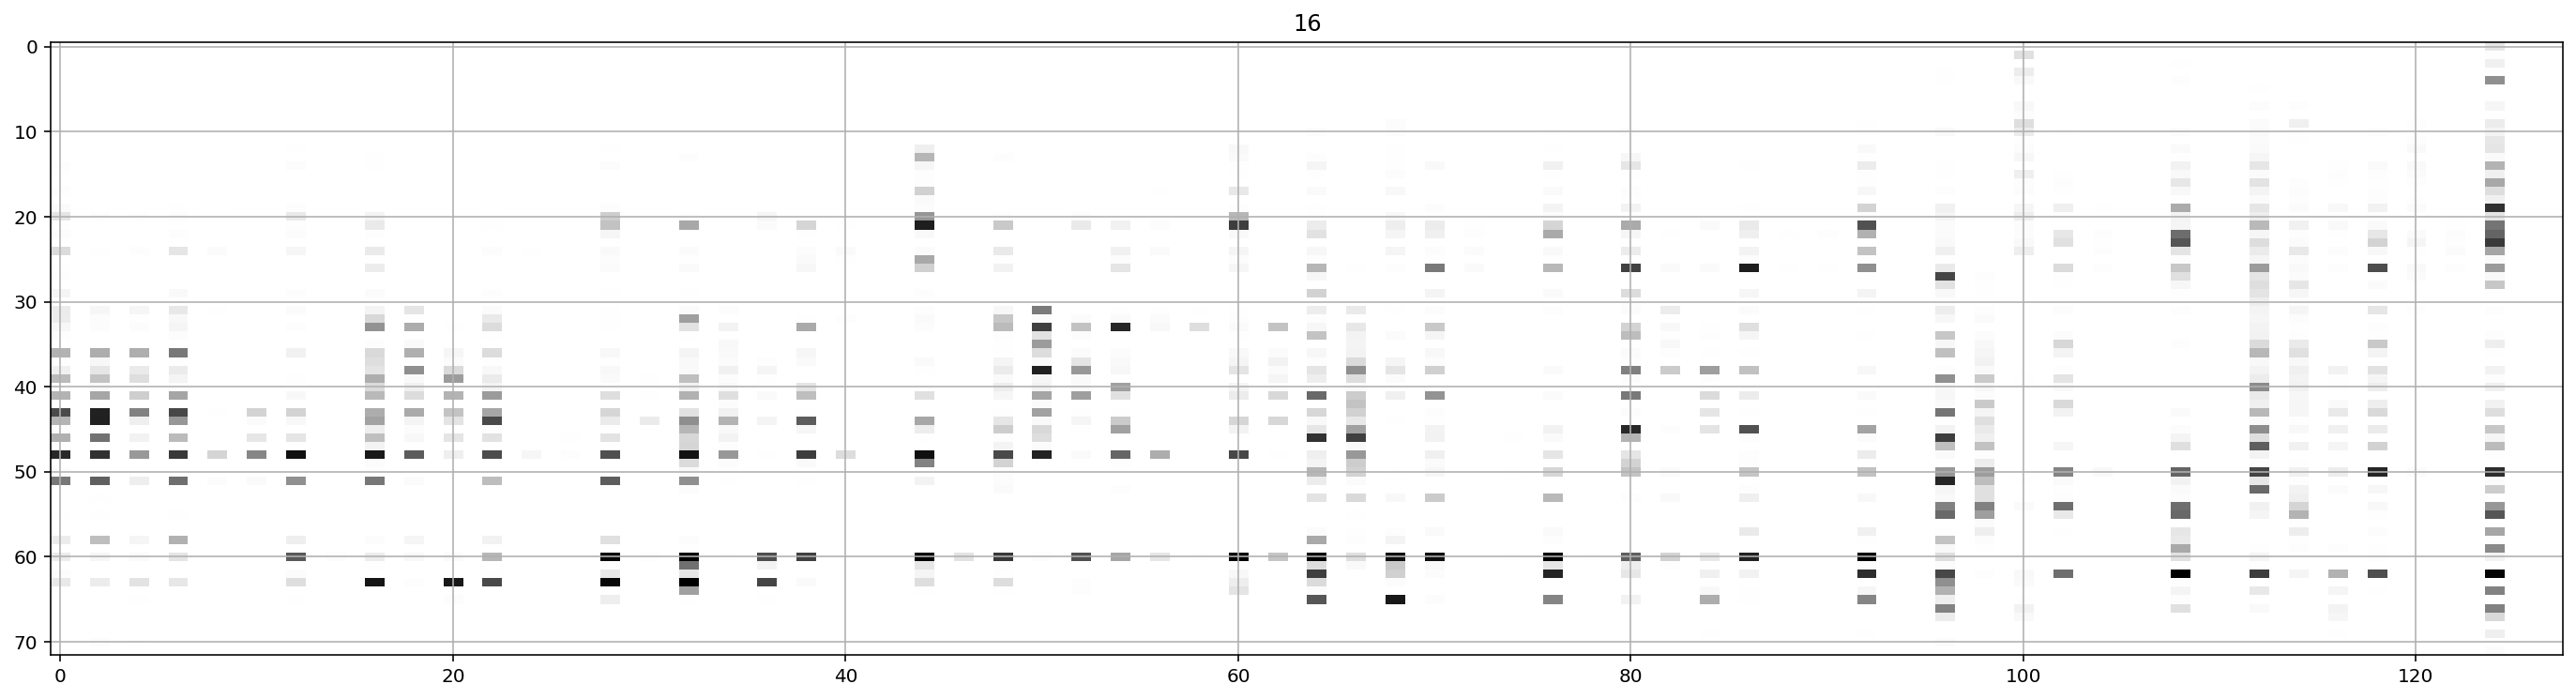

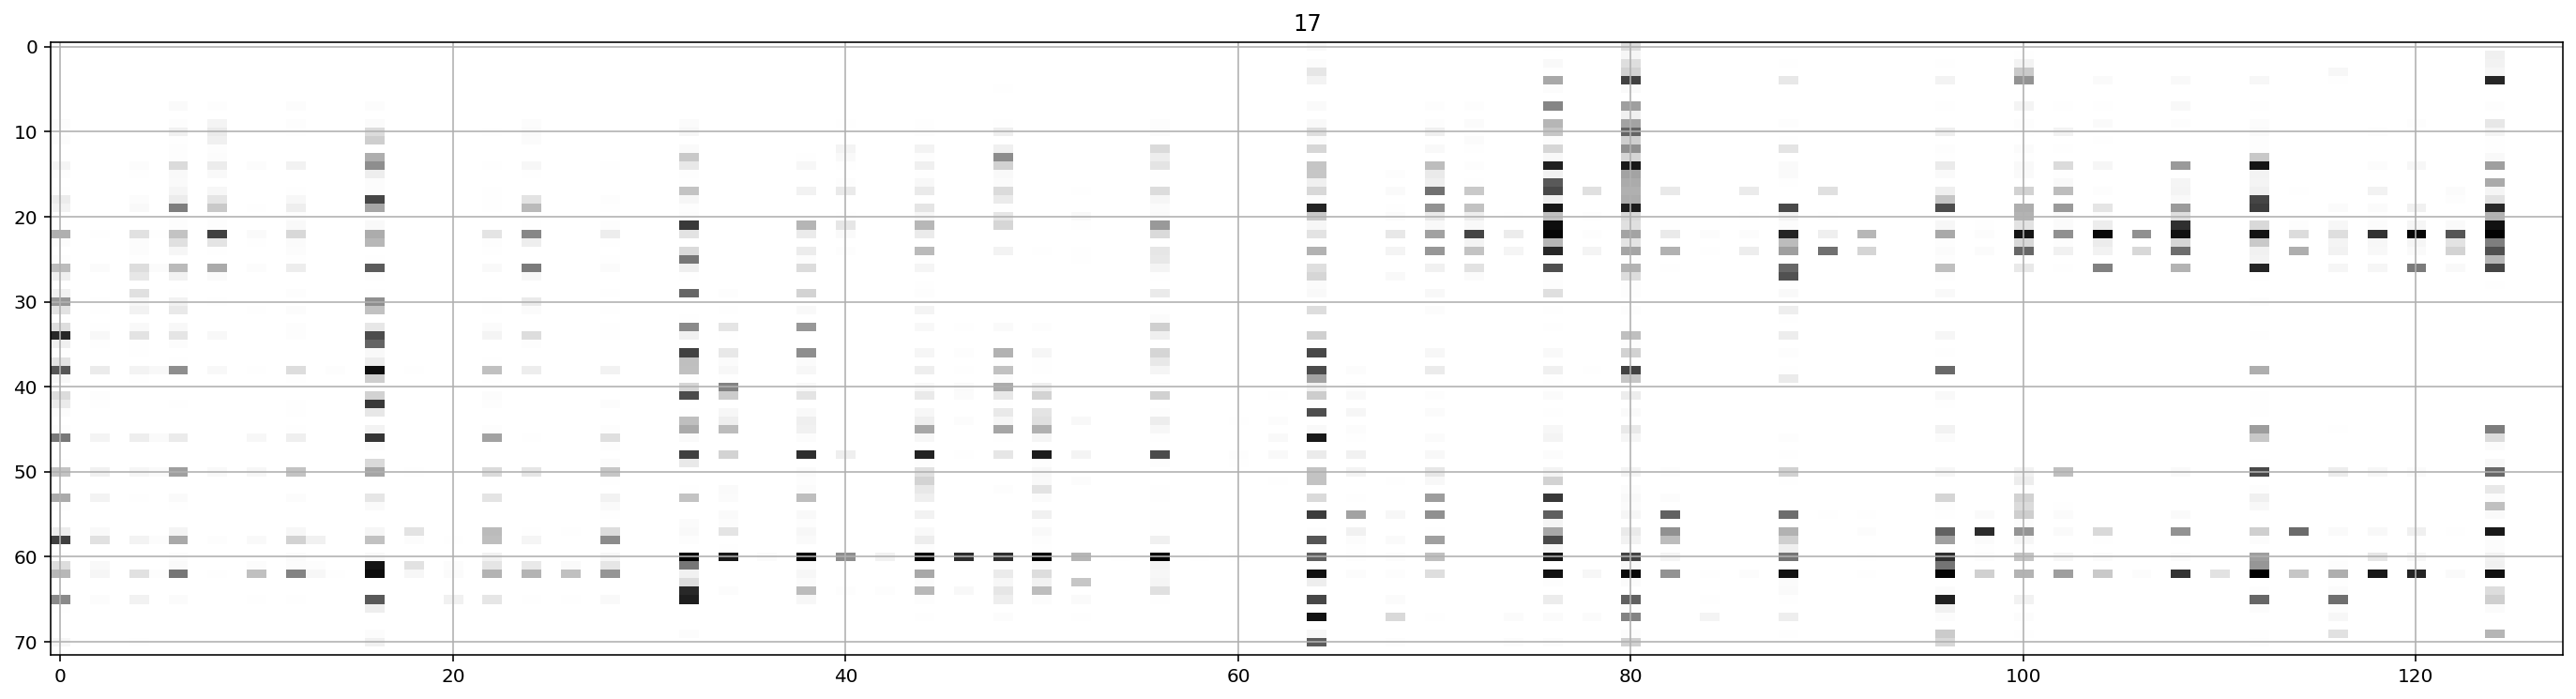

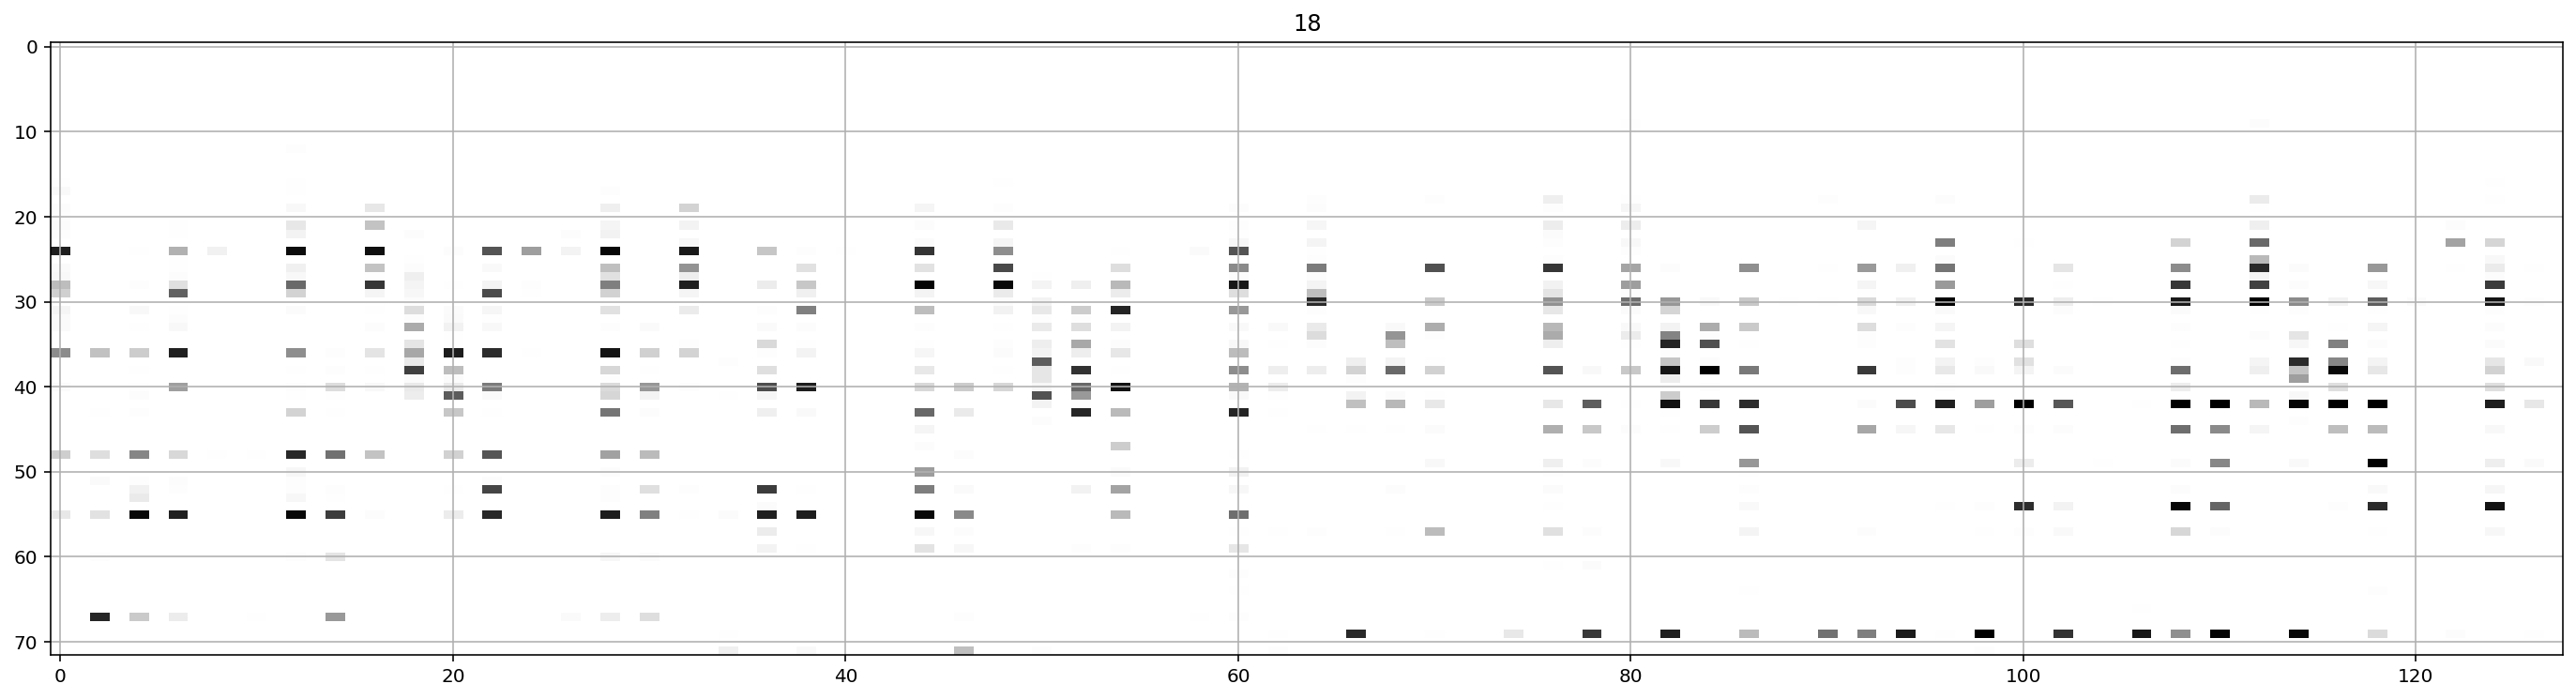

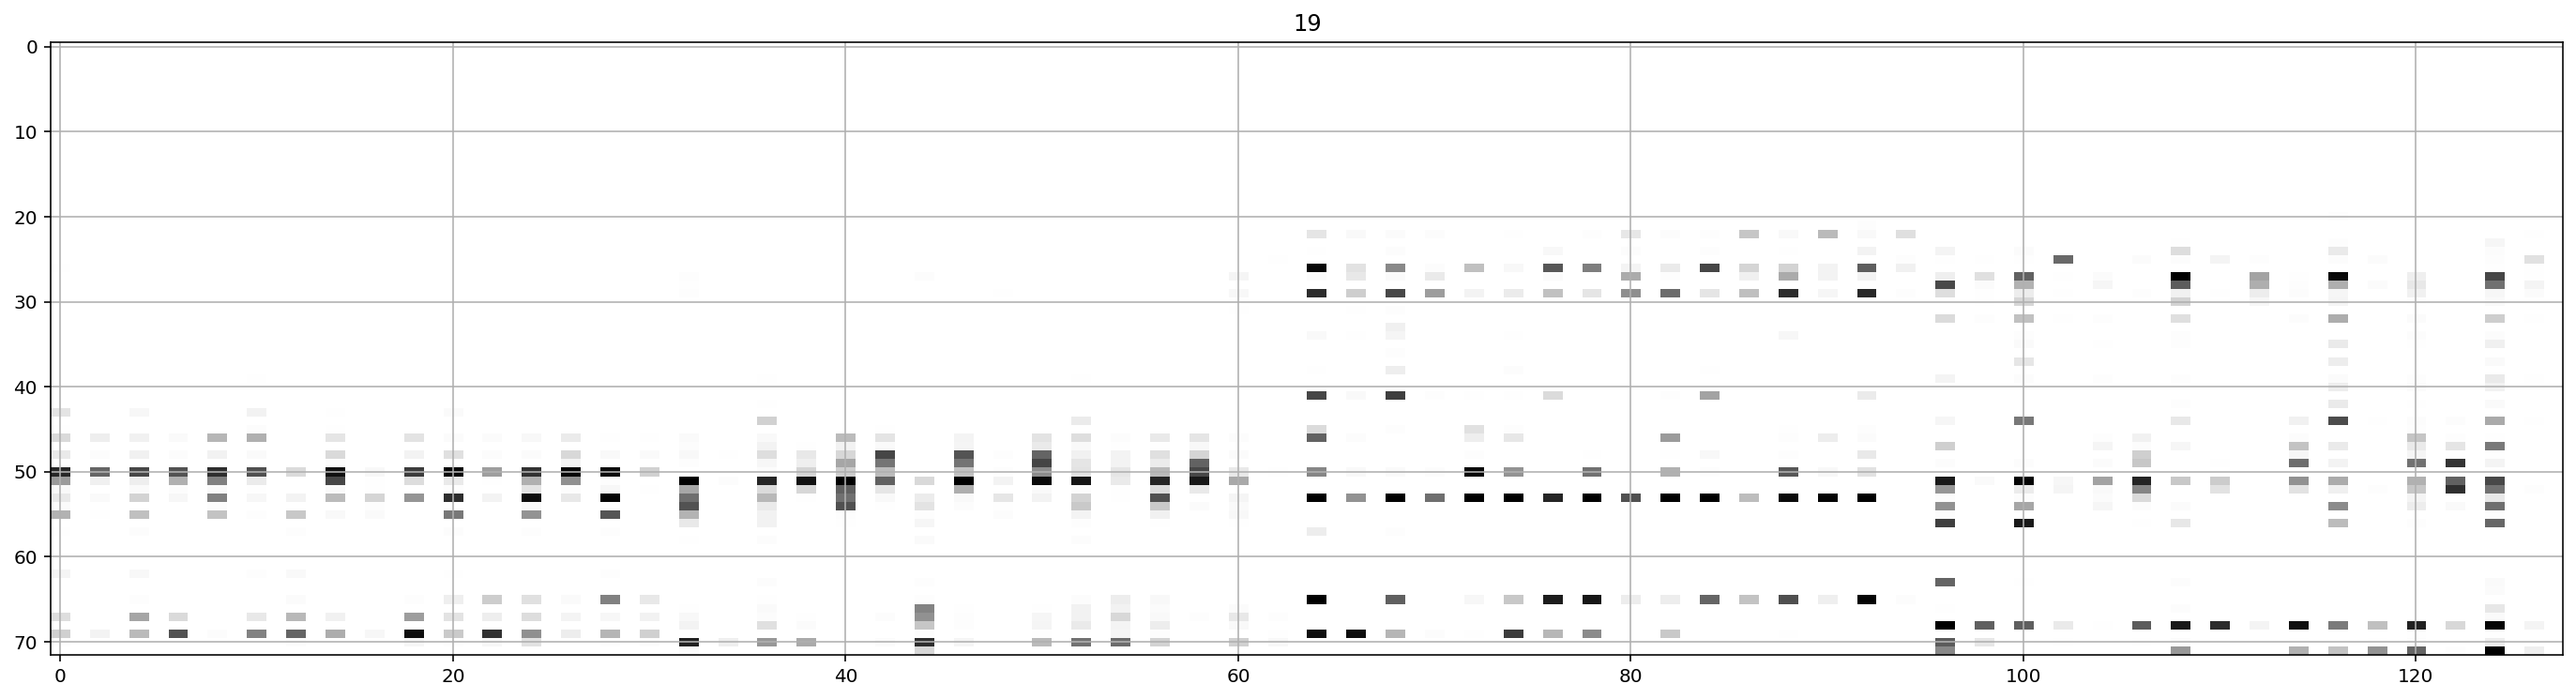

In [ ]:
for i in range(20):
  # x_rand = x_vecs[i:i + 1]

  # y_song = decoder.predict(x_rand)[0]


  plt.figure(figsize=(24, 6))
  plt.title(i)
  plt.imshow( np.flipud( y_song_rounded[i].T ) , aspect='auto')
  plt.set_cmap('gray_r')
  plt.grid(True)




```
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

# This is formatted as code
```



In [ ]:
generate_midi_song(y_song_rounded[0])
!fluidsynth -ni font.sf2 this.mid -F output.wav -r 44100
Audio('output.wav')

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'output.wav'..
